In [1]:
def get_CDF_data(data):

    # sort the data
    data_sorted = np.sort(data)
    # calculate the proportional values of sample
    p = 1. * np.arange(len(data)) / (len( data) - 1)

    return data_sorted,p

In [13]:
# Standard library
import os
import sys
import pathlib
from glob import glob

# Scientific computing and data handling
import numpy as np
import pandas as pd
from scipy import stats
import xarray as xr

# Geospatial libraries
import rioxarray
import rasterio as rio
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS, Proj, transform
import osmnx as ox

# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt  # Removed duplicate import
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DayLocator
import matplotlib.dates as mdates
import seaborn as sns
import contextily as ctx

# Other
import yaml

# Custom repository path
repo_dir = '/eos/jeodpp/home/users/mosfran/data/po_casestudy/zenodo/repo'
sys.path.append(repo_dir)

# Matplotlib font configuration
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# Formatter function for plots
def my_formatter(x, pos):
    if x.is_integer():
        return str(int(x))
    else:
        return str(np.round(x, 1))


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# from utils.general import *
# from utils.hs import *
# from lisflood.plots.maps import *
from plot_tools import *
with open(os.path.join(repo_dir,"hsPP.yml"), "r") as stream:
    try:
        hsPP=yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [6]:
main_dir='/eos/jeodpp/home/users/mosfran/data/po_casestudy/zenodo/'
cal_out_dir=os.path.join(main_dir,'experiments_output')
out_dir=os.path.join(main_dir,'plots')

In [7]:
# read shapefile of calibrated subcatchments
catch_shp=(os.path.join(main_dir,'shp_files','catchments.gpkg'))
catchments=gpd.read_file(catch_shp)
# catchments.index=catchments.ID


monthly_KGE=pd.read_csv(os.path.join(cal_out_dir,'Performance_allexp.csv'))


In [8]:

exp_names=['NOBP', 'NOBPNEWSD', 'NOBPNEWSD3', 'benchmark', 'BPNEWSD3', 'BPNEWSD']
mosaic=[['benchmark','BPNEWSD','BPNEWSD3'],['NOBP', 'NOBPNEWSD', 'NOBPNEWSD3']]


In [9]:
# create empty dictionary
summary_dict=dict.fromkeys(exp_names)

Plot study Area

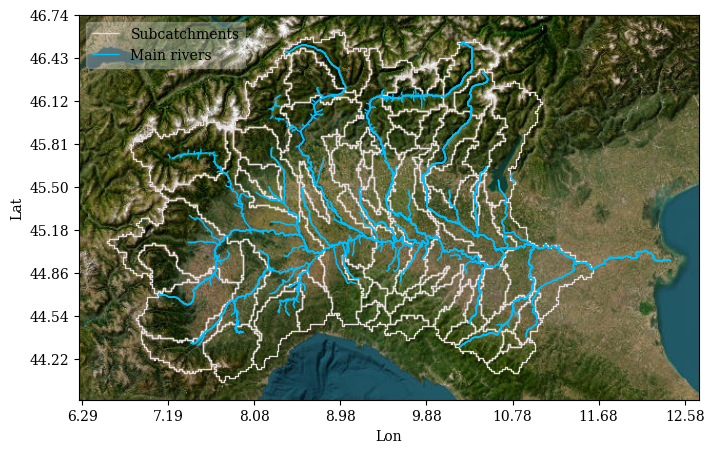

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

catchments['geometry'].to_crs(epsg=3857).boundary.plot(color='#e6dcdc', linewidth=1,ax=ax,label='Subcatchments')
# 4. Add basemap
# Define bounding box or place
# Add text labels
filtered = gpd.read_file(os.path.join(main_dir,'shp_files','rivers.gpkg'))
riversp = gpd.GeoDataFrame(filtered, geometry='geometry').to_crs(epsg=3857)
riversp.plot(color='deepskyblue', linewidth=1,ax=ax, label='Main rivers')
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery,attribution=False)
# Extract centroids in lat/lon
temp_latlon = catchments.to_crs(epsg=4326)

proj_wgs84 = Proj(init="epsg:4326")
proj_web_mercator = Proj(init="epsg:3857")

# Function to convert coordinates from EPSG:3857 to EPSG:4326
def transform_coord(x, y):
    lon, lat = transform(proj_web_mercator, proj_wgs84, x, y)
    return lon, lat

# Get current ticks (in EPSG:3857)
xticks = ax.get_xticks()
yticks = ax.get_yticks()

# Convert from EPSG:3857 to EPSG:4326 for both x and y
lon_ticks, lat_ticks = zip(*[transform_coord(x, y) for x, y in zip(xticks, yticks)])

# Set the new labels for latitude and longitude
ax.set_xticklabels([f'{lon:.2f}' for lon in lon_ticks]);
ax.set_yticklabels([f'{lat:.2f}' for lat in lat_ticks]);

ax.set_xlabel('Lon');
ax.set_ylabel('Lat');

# Add legend for subcatchments and rivers
legend = ax.legend(loc='upper left', fontsize=10, frameon=True)
# legend.get_frame().set_facecolor('#333333')  # Dark gray background
# legend.get_frame().set_edgecolor('black')    # Optional: white border
legend.get_frame().set_alpha(0.3)            # Optional: slight transparency
# for text in legend.get_texts():
#     text.set_color("white")                  # Make text visible on dark background
fig.savefig(os.path.join(out_dir,'study_area.png'), bbox_inches="tight")


create summary plot

In [ ]:
# fill in dictionary with calibration output
for i in exp_names:
    summary_dict[i]=pd.read_csv(os.path.join(cal_out_dir,i,'summary','BestParams.csv'),index_col="ObsID")
catchments=catchments[catchments['ID'].isin(summary_dict['NOBPNEWSD3'].index)]
summary_dict[i].columns

Index(['randId', 'UpperZoneTimeConstant', 'LowerZoneTimeConstant',
       'GwPercValue', 'LZThreshold', 'b_Xinanjiang', 'PowerPrefFlow',
       'SnowMeltCoef', 'CalChanMan1', 'CalChanMan2', 'LakeMultiplier',
       'adjust_Normal_Flood', 'ReservoirRnormqMult', 'QSplitMult', 'GwLoss',
       'Kling Gupta Efficiency', 'Correlation', 'Signal ratio (s/o) (Bias)',
       'Noise ratio (s/o) (Spread)', 'sae', 'generation', 'runNumber',
       'Unnamed: 22', 'corrRank', 'saeRank', 'KGERank', 'paretoRank'],
      dtype='object')

In [142]:
catchments_list=summary_dict[i].index

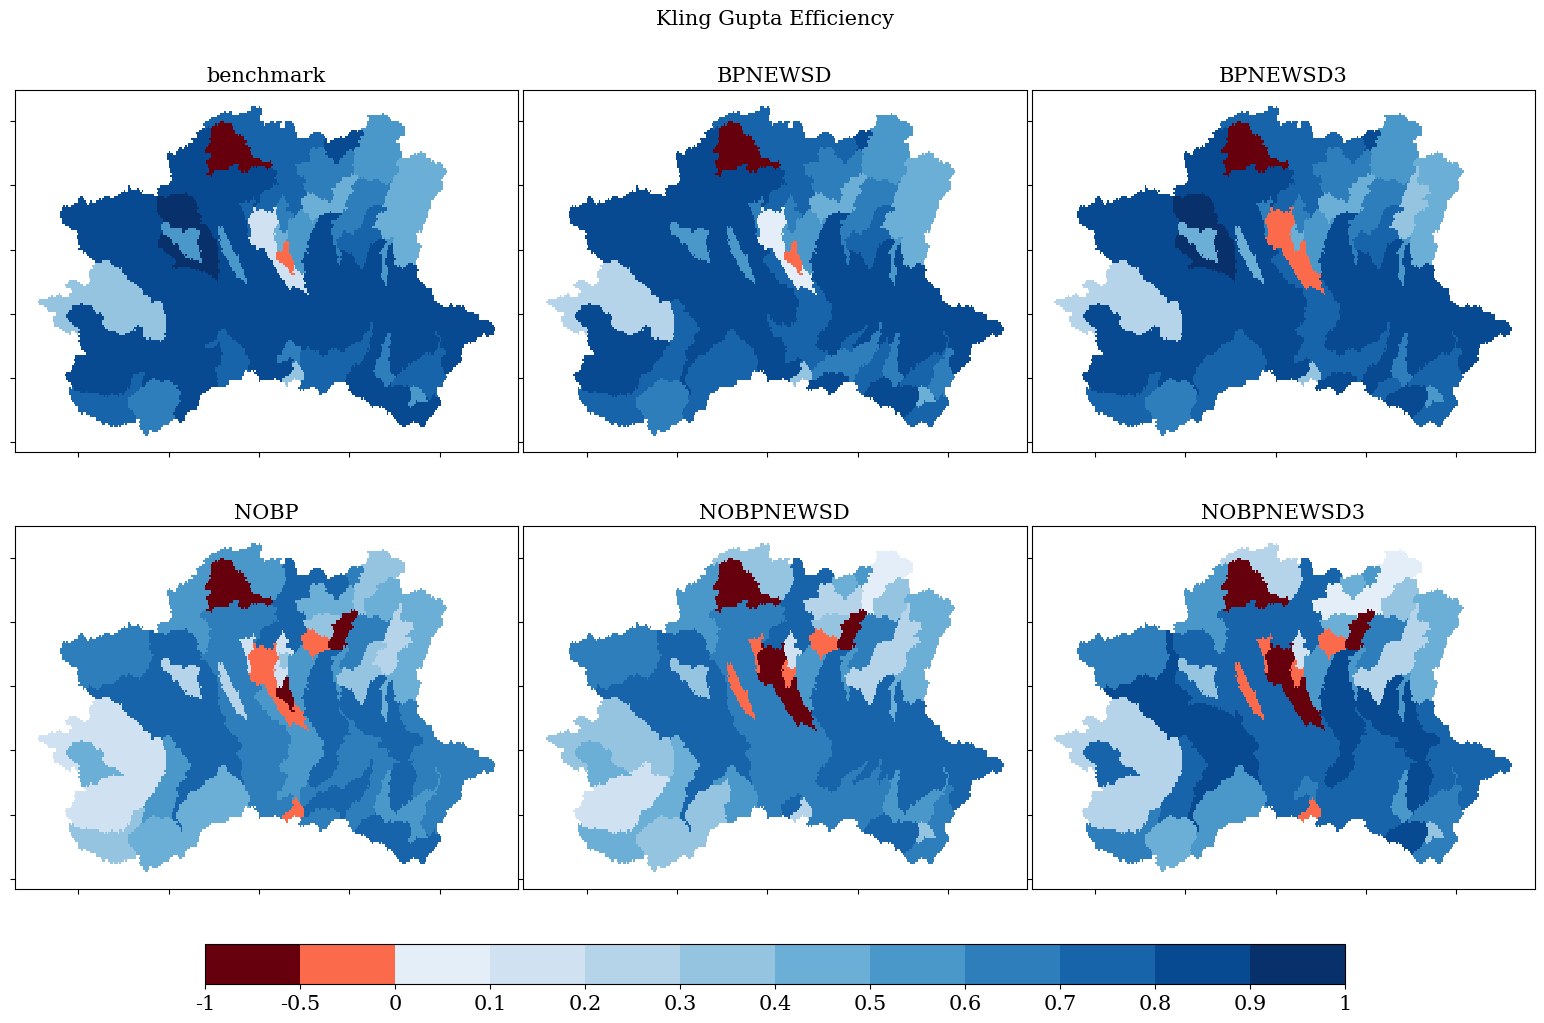

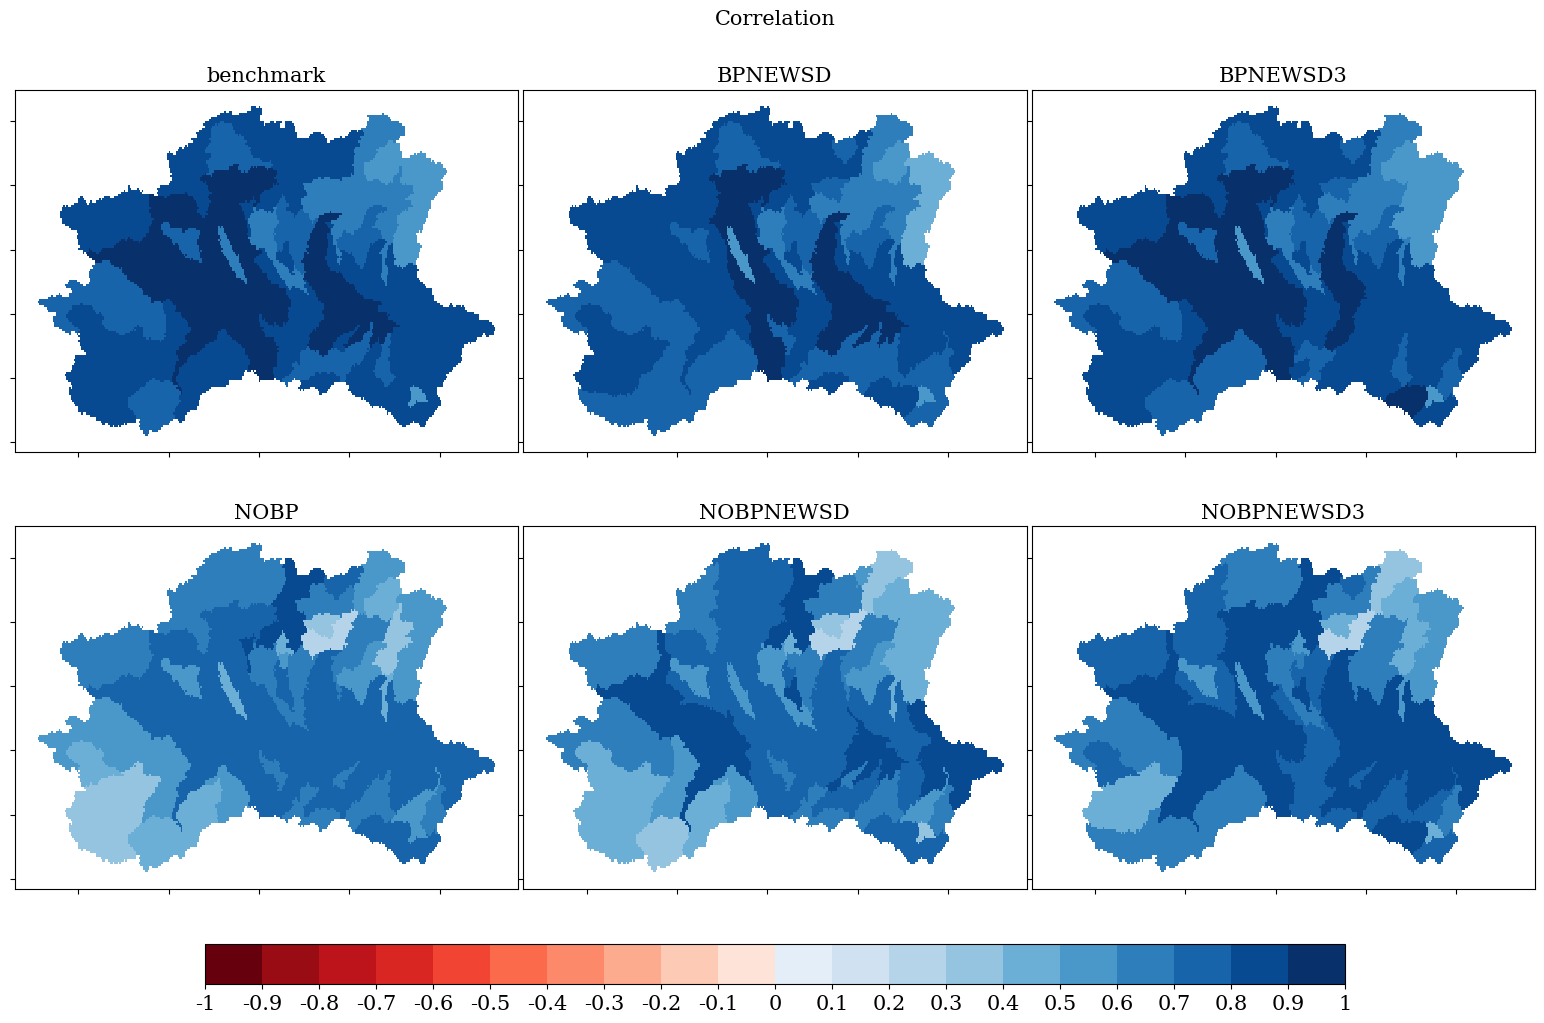

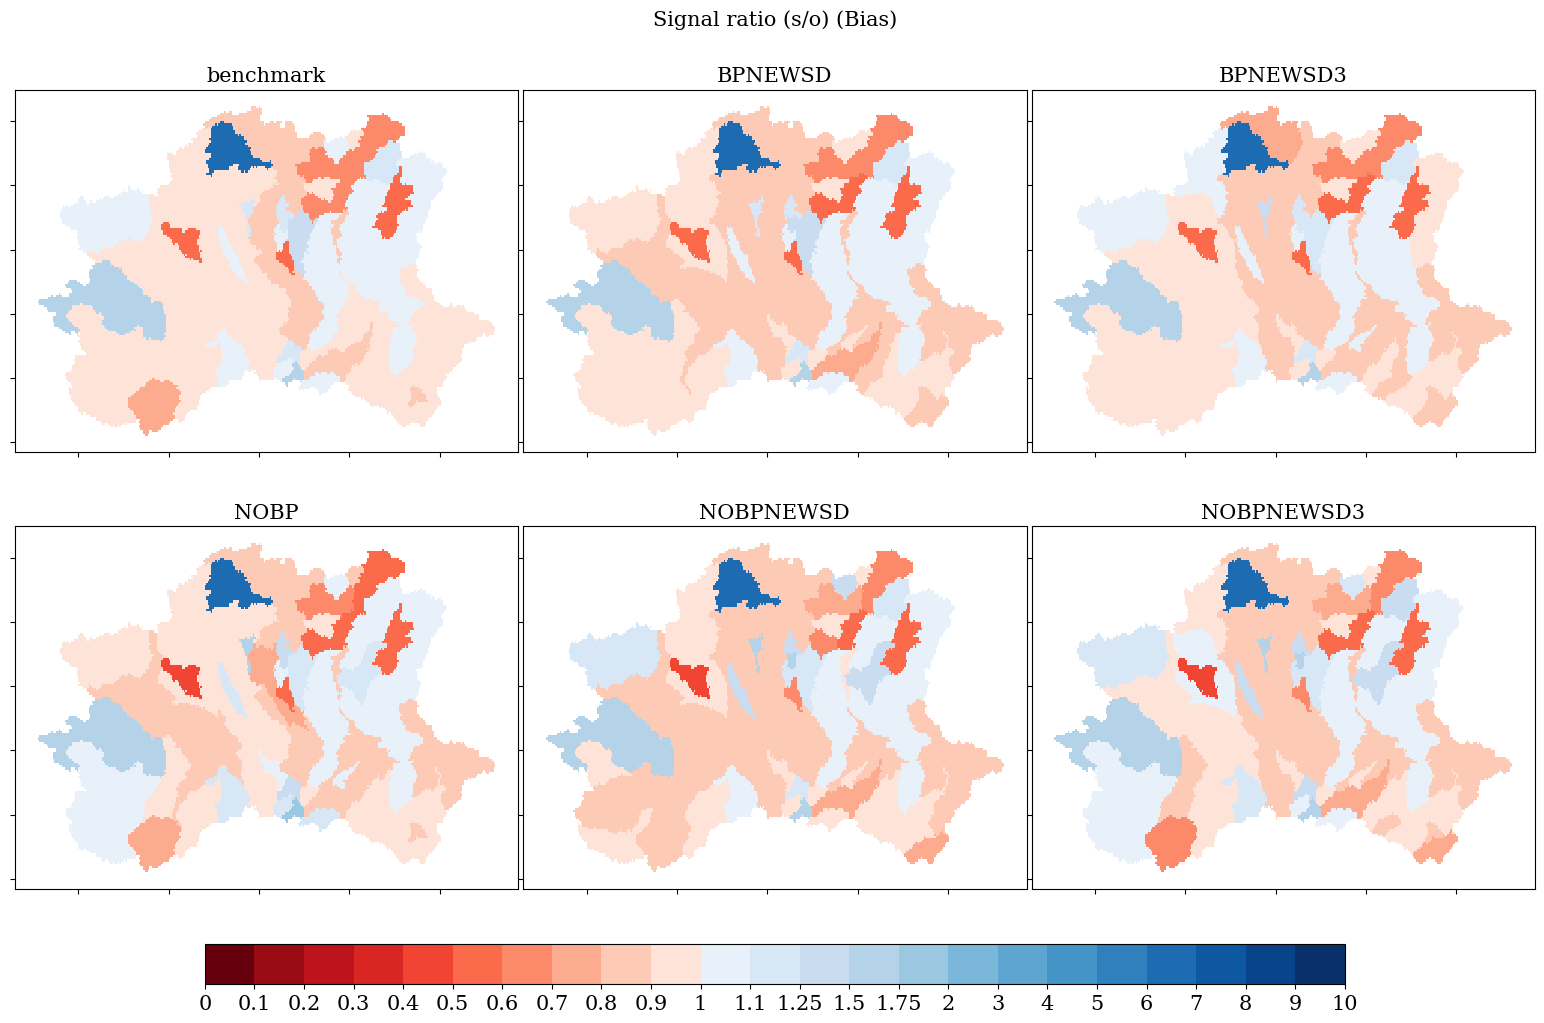

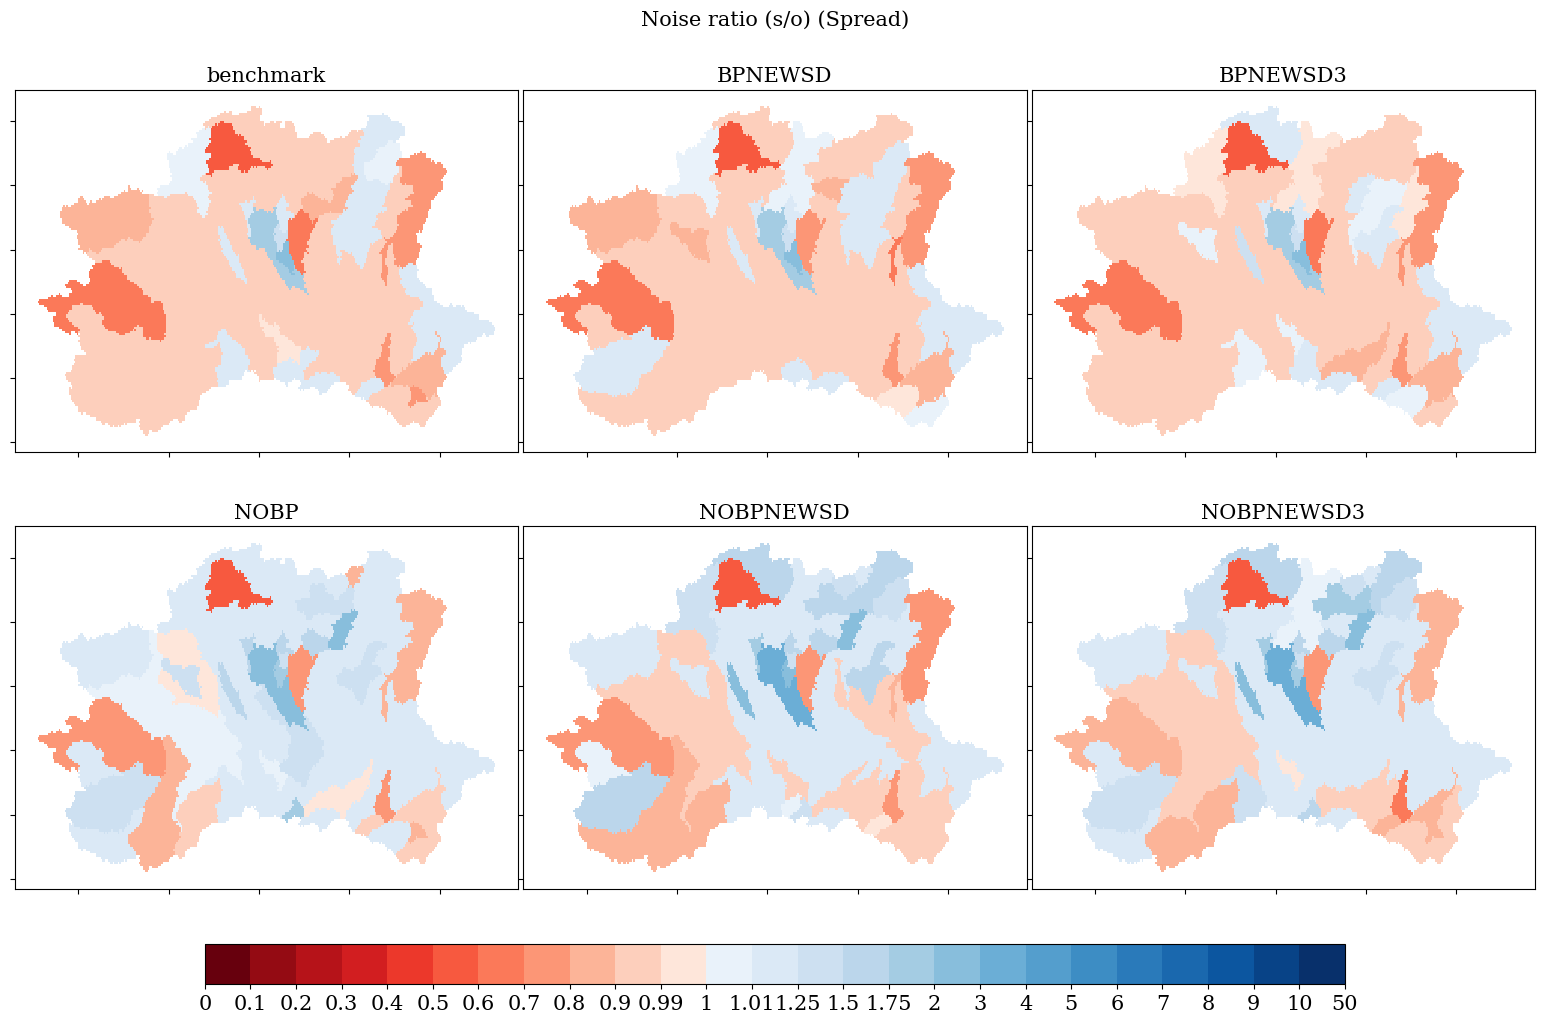

In [143]:
var2print_list=['Kling Gupta Efficiency', 'Correlation', 'Signal ratio (s/o) (Bias)','Noise ratio (s/o) (Spread)']

cmap = matplotlib.cm.RdBu
var2print_list=['Kling Gupta Efficiency', 'Correlation', 'Signal ratio (s/o) (Bias)','Noise ratio (s/o) (Spread)']
hsPP_reference=['KGE','KGE_r','KGE_B','KGE_y']
for i,var2print in enumerate(var2print_list):
    levels=hsPP[hsPP_reference[i]]['levels']
    remove=['(', ')', '/',' ']
    var2print_name=var2print.translate({ord(x): '' for x in remove})

    fig = plt.figure(figsize = (19,10))

    ax=fig.subplot_mosaic(mosaic)
    #loop to find min and max
    min_z=summary_dict['benchmark'][var2print].min()
    max_z=summary_dict['benchmark'][var2print].max()
    for e in exp_names:
        min_z=min(summary_dict[e][var2print].min(),min_z)
        max_z=max(summary_dict[e][var2print].max(),max_z)

    #create discrete colormap
    #levels=[min_z,-10,-1,-0.5,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    mid_value=hsPP[hsPP_reference[i]]['mid']
    mid_value_index=levels.index(mid_value)
    minP=[levels[0:mid_value_index],'Reds_r']
    maxP=[levels[mid_value_index+1::],'Blues']
    # midP=[mid_value,'grey']
    cmap_map=build_cmap(minP=minP,midP=None,maxP=maxP)
    cmap_map.set_bad('white')
    norm = matplotlib.colors.BoundaryNorm(boundaries=levels, ncolors=cmap_map.N)

    #plot
    for i,e in enumerate(exp_names):
        temp=catchments.merge(summary_dict[e],right_index=True,left_on='ID',how='inner')
        temp[var2print]=temp[var2print].replace(mid_value,np.nan)
        temp.plot(ax=ax[e],column=var2print, cmap=cmap_map, norm=norm)
        ax[e].set_xticklabels([]),ax[e].set_yticklabels([])
        ax[e].set_title(e,fontsize=15)

        exp_cdf=get_CDF_data(summary_dict[e][var2print])

    cbar=fig.add_axes([0.2,0.005,0.6,0.04])

    fig.suptitle(var2print, y=0.98,size=15)
    thebar=fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap_map),cax=cbar, orientation = "horizontal",pad=-1)

    fig.savefig(os.path.join(out_dir,f'{var2print_name}.png'),bbox_inches='tight')
    thebar.set_ticks(levels)
    levels_str=[str(x) for x in levels]
    thebar.ax.set_xticklabels(levels_str,fontsize=15);
    fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.01, 
                        hspace=0.2)

plot monthly performance - calculated in the budyko script

In [144]:
exp_names=['NOBP', 'NOBPNEWSD', 'NOBPNEWSD3', 'benchmark', 'BPNEWSD3', 'BPNEWSD']
exp_color=['#BD1768','#E45700','#FFD400','black','#6AABF9','#6746FF']
new_exp_names=['NOBP', 'NOBP-WT', 'NOBP-3M', 'benchmark', 'BP-3M', 'BP-WT']


In [145]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

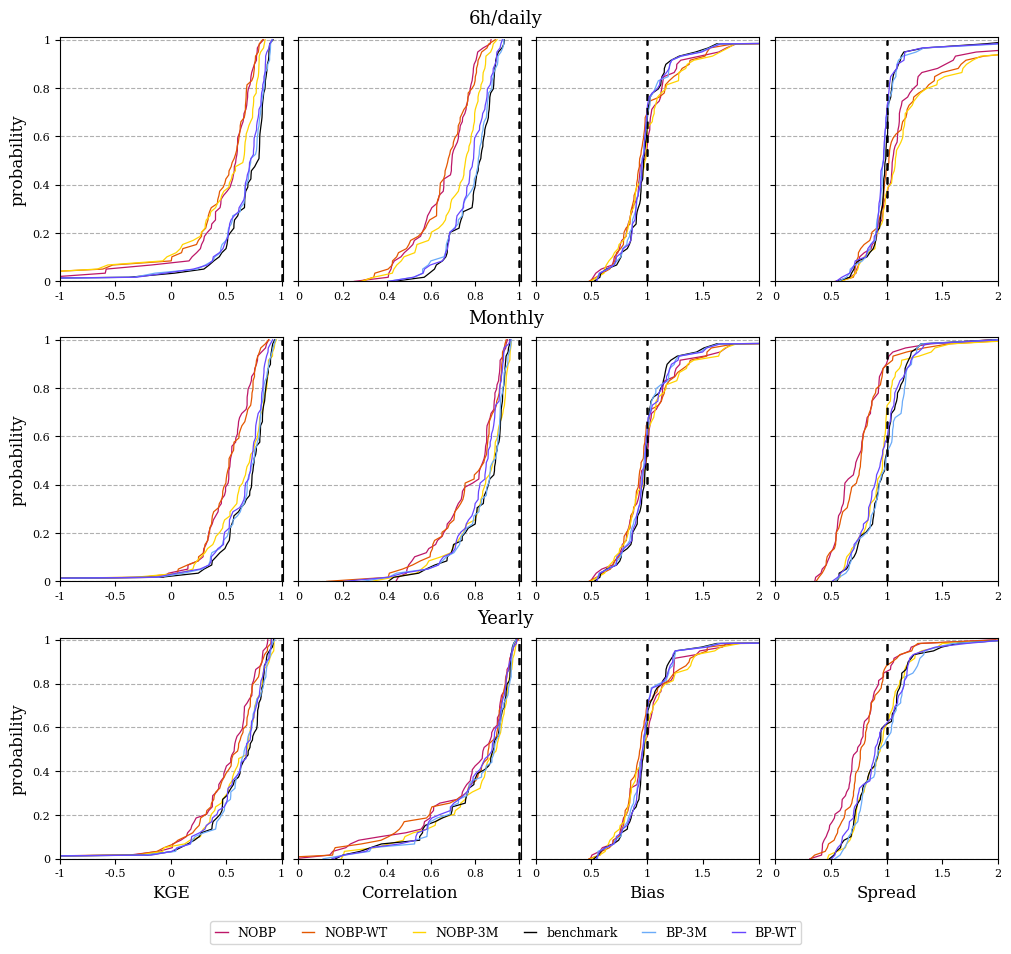

In [ ]:
from mpl_toolkits.axes_grid1 import axes_grid
formatter = FuncFormatter(my_formatter)

monthly_KGE.index=monthly_KGE['ObsID']
# monthly_KGE['exp'] = monthly_KGE['exp'].replace(exp_mapping)

# fig = plt.figure(figsize = (19,5))
var2print_list=['KGE','corr','bias','var_ratio']
fig = plt.figure(layout='constrained',figsize=(10,9))
subfigs = fig.subfigures(3, 1, wspace=0,hspace=0)
axs = (np.array(subfigs)).reshape(-1)
# ax=fig.subplot_mosaic([var2print_list])
for g, subfigsnest in enumerate(axs):
    # fig = plt.figure(figsize = (17,4))
    # ax=fig.subplot_mosaic([var2print_list])
    
    ax = subfigsnest.subplots(1, 4)

    for i,var2print in enumerate(var2print_list):
        t=['','M','Y'][g]
        title=['6h/daily','Monthly','Yearly'][g]
        var2print_label=['KGE','Correlation','Bias','Spread']
        var2printv=var2print+t

        subfigsnest.suptitle(title,size=13)
        for f,e in enumerate(exp_names):
            monthly_df=monthly_KGE[monthly_KGE['exp']==e]
            temp=catchments.merge(monthly_df,right_index=True,left_on='ID',how='inner')
            # temp[var2print]=temp[var2print].replace(mid_value,np.nan)
            # temp.plot(ax=ax[var2print],column=var2print, cmap=cmap_map, norm=norm)
            # ax[var2print].set_xticklabels([]),ax[e].set_yticklabels([])
            # ax[var2print].set_title(e,fontsize=15)

            exp_cdf=get_CDF_data(temp[var2printv])
            # if e== 'benchmark':ax['NULL'].plot(exp_cdf[0], exp_cdf[1], label=e, c='black')
            
            ax[i].plot(exp_cdf[0], exp_cdf[1], label=e,linewidth=0.9,c=exp_color[f])
            max_plot=max(exp_cdf[0].max(),1)
            if var2print=='KGE':
                min_plot=-1
            else:min_plot=min(exp_cdf[0].min(),0)
            if max_plot==1:max_plot=1.01
            elif max_plot>2:max_plot=2
            ax[i].axis([min_plot, max_plot, 0, 1.01])
            ax[i].vlines(1,0,1,color='black',linewidth=1,linestyle = (0,(5,5)))
            ax[i].grid(axis = 'y',linestyle = '--')
            if t!='Y':ax[i].set_xlabel('')
            else:  ax[i].set_xlabel(var2print_label[i],size=12)

            if i ==0:
                ax[i].set_ylabel('probability',size=12)
                ax[i].tick_params(axis='y', labelsize=8)
                ax[i].yaxis.set_major_formatter(formatter)

            else:
                ax[i].set_yticklabels('')
                
            ax[i].tick_params(axis='x', labelsize=8)
            ax[i].xaxis.set_major_formatter(formatter)
            
# ax[3].legend(handlelength=1,ncol=len(exp_names),loc='upper center',bbox_to_anchor=(-1.5, -1))
fig.legend(
    labels=new_exp_names,
    handles=[plt.Line2D([0], [0], color=exp_color[i], lw=1) for i in range(len(new_exp_names))],
    loc='lower center',
    ncol=len(new_exp_names),
    fontsize=9,
    handlelength=1,
    bbox_to_anchor=(0.5, -0.05)
)
fig.subplots_adjust(wspace=0.08, hspace=1, right=0.86,left=0.1,bottom=0.15,top=0.89)
fig.savefig(os.path.join(out_dir,'KGE_performace.png'), bbox_inches="tight")


plot FDC JS

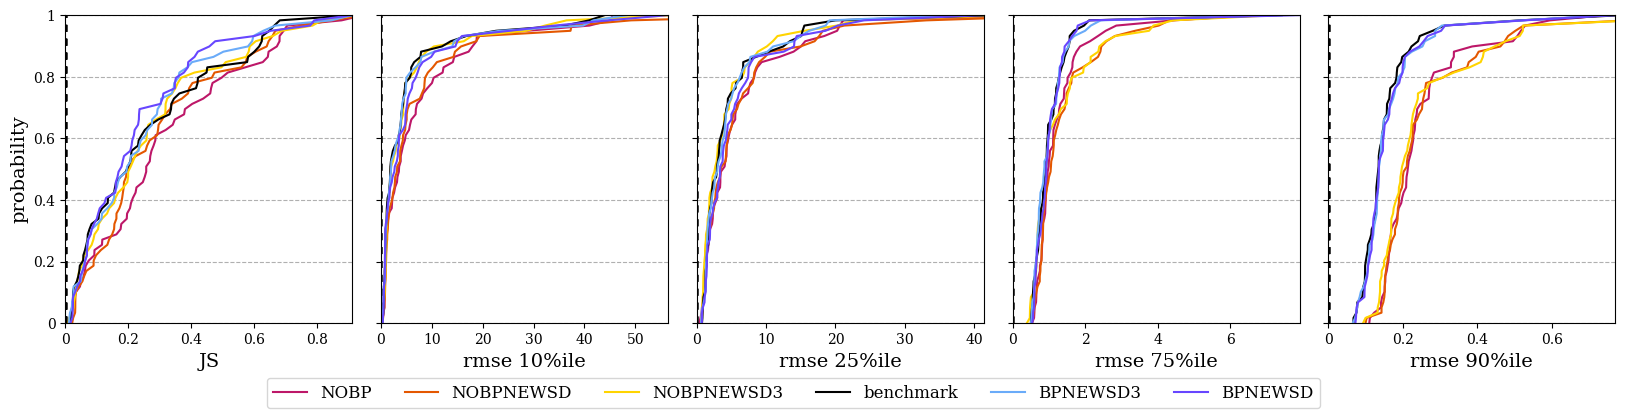

In [ ]:
# monthly_KGE=pd.read_csv('/eos/jeodpp/home/users/mosfran/data/po_casestudy/LISFLOOD_data/cal_out/Monthly_performance_allexp.csv')
# monthly_KGE.index=monthly_KGE['ObsID']
# fig = plt.figure(figsize = (19,5))
var2print_list=['JS','rmse_10NN','rmse_25NN','rmse_75NN','rmse_90NN']
var2print_label=['JS','rmse 10%ile','rmse 25%ile','rmse 75%ile','rmse 90%ile']

# ax=fig.subplot_mosaic([var2print_list])

fig = plt.figure(figsize = (20,4))
ax=fig.subplot_mosaic([var2print_list])

for v,var2print in enumerate(var2print_list):
    ax[var2print].grid(axis = 'y',linestyle = '--')
    for i,e in enumerate(exp_names):
        monthly_df=monthly_KGE[monthly_KGE['exp']==e]
        temp=catchments.merge(monthly_df,right_index=True,left_on='ID',how='inner')
        exp_cdf=get_CDF_data(temp[var2print])
        # if e== 'benchmark':ax['NULL'].plot(exp_cdf[0], exp_cdf[1], label=e, c='black')
        ax[var2print].vlines(0.001,0,1,color='black',linewidth=1,linestyle = (0,(5,5)))
        ax[var2print].plot(exp_cdf[0], exp_cdf[1], label=e,c=exp_color[i])
        max_plot=max(exp_cdf[0].max(),0.1)
        min_plot=min(exp_cdf[0].min(),0)
        ax[var2print].axis([min_plot, max_plot, 0, 1])
        ax[var2print].set_xlabel(var2print_label[v],fontsize=14)
        # ax[var2print].legend()
        if var2print==var2print_list[0]:
            ax[var2print].set_ylabel('probability',fontsize=14)
            ax[var2print].yaxis.set_major_formatter(formatter)
            # ax[var2print].yticks(fontsize=10)
        else:
            ax[var2print].set_ylabel('')
            ax[var2print].set_yticklabels('')
        ax[var2print].xaxis.set_major_formatter(formatter)
        


        
plt.subplots_adjust(wspace=0.1)
plt.legend(prop={'size': 12}, ncol=6,loc=0,bbox_to_anchor=(0, -0.6, 0, 0.45))
fig.savefig(os.path.join(out_dir,'mse_performance.png'), bbox_inches="tight")



Check best catchments according to experiment

In [148]:
var2print='Kling Gupta Efficiency'
df_best=pd.DataFrame(index=summary_dict['BPNEWSD3'].index)
# s=summary_dict['benchmark'][var2print].rename('benchmark')
# df_best=df_best.merge(s,how='left',right_index=True,left_index=True )
for e in list(exp_names):
    s=summary_dict[e][var2print].rename(e)
    df_best=df_best.merge(s,how='left',right_index=True,left_index=True )


In [149]:
#assign significance difference threshold
diff_sign=0.05
BP_exp=['benchmark','BPNEWSD','BPNEWSD3']
NBP_exp=['NOBP','NOBPNEWSD','NOBPNEWSD3']

In [150]:
#find
if var2print== 'Kling Gupta Efficiency':
    best_exp=df_best.idxmax(axis=1)
    best_BP=df_best[BP_exp].idxmax(axis=1)
    best_NBP=df_best[NBP_exp].idxmax(axis=1)
    for i in df_best.index:
        best_metric_value=df_best.at[i,best_exp[i]]
        max_diff=max(abs(df_best.loc[i,:]-best_metric_value))
        if max_diff<diff_sign:
            best_exp[i]='NO_DIFF'

    for i in df_best.index:
        best_metric_value=df_best.at[i,best_BP[i]]
        max_diff=max(abs(df_best.loc[i,BP_exp]-best_metric_value))
        if max_diff<diff_sign:
            best_BP[i]='NO_DIFF'
    for i in df_best.index:
        best_metric_value=df_best.at[i,best_NBP[i]]
        max_diff=max(abs(df_best.loc[i,NBP_exp]-best_metric_value))
        if max_diff<diff_sign:
            best_NBP[i]='NO_DIFF'
else:
    best_exp=(df_best-1).abs()    
    best_exp=df_best.idxmin(axis=1)
    best_BP=df_best[BP_exp].idxmin(axis=1)
    best_NBP=df_best[NBP_exp].idxmin(axis=1)
    for i in df_best.index:
        best_metric_value=df_best.at[i,best_exp[i]]
        max_diff=max(abs(df_best.loc[i,:]-best_metric_value))
        if max_diff<diff_sign:
            best_exp[i]='NO_DIFF'

    for i in df_best.index:
        best_metric_value=df_best.at[i,best_BP[i]]
        max_diff=max(abs(df_best.loc[i,BP_exp]-best_metric_value))
        if max_diff<diff_sign:
            best_BP[i]='NO_DIFF'
    for i in df_best.index:
        best_metric_value=df_best.at[i,best_NBP[i]]
        max_diff=max(abs(df_best.loc[i,NBP_exp]-best_metric_value))
        if max_diff<diff_sign:
            best_NBP[i]='NO_DIFF'


In [151]:
# Define the mapping from old to new names
exp_mapping = {
    'NOBP': 'NOBP',
    'NOBPNEWSD': 'NOBP-WT',
    'NOBPNEWSD3': 'NOBP-3M',
    'benchmark': 'benchmark',
    'BPNEWSD3': 'BP-3M',
    'BPNEWSD': 'BP-WT',
    'NO_DIFF':'no difference'
}

In [152]:
exp_color=['#BD1768','#E45700','#FFD400','black','#6AABF9','#6746FF']
new_exp_names=['NOBP', 'NOBP-WT', 'NOBP-3M', 'benchmark', 'BP-3M', 'BP-WT']

In [153]:
color_dict = {
    'BP-WT': '#B3A5FF',       # lighter blue
    'BP-3M': '#B9DAFA',       # lighter sky blue
    'NOBP': '#E68FB1',        # lighter pinkish-red
    'NOBP-WT': '#F7A766',     # lighter orange
    'NOBP-3M': '#FFF199',     # lighter yellow
    'no difference': '#D3D3D3' # light grey
   # medium grey instead of black for lighter tone
}

In [154]:
import matplotlib.patches as mpatches

In [155]:
# Define lighter color palette
color_dict = {
    'BP-WT': '#B3A5FF',        # light blue
    'BP-3M': '#B9DAFA',        # light sky blue
    'NOBP': '#E68FB1',         # light pink-red
    'NOBP-WT': '#F7A766',      # light orange
    'NOBP-3M': '#FFF199',      # light yellow
    'benchmark': '#808080'     # medium gray
    # 'no difference' handled with hatching, not color
}

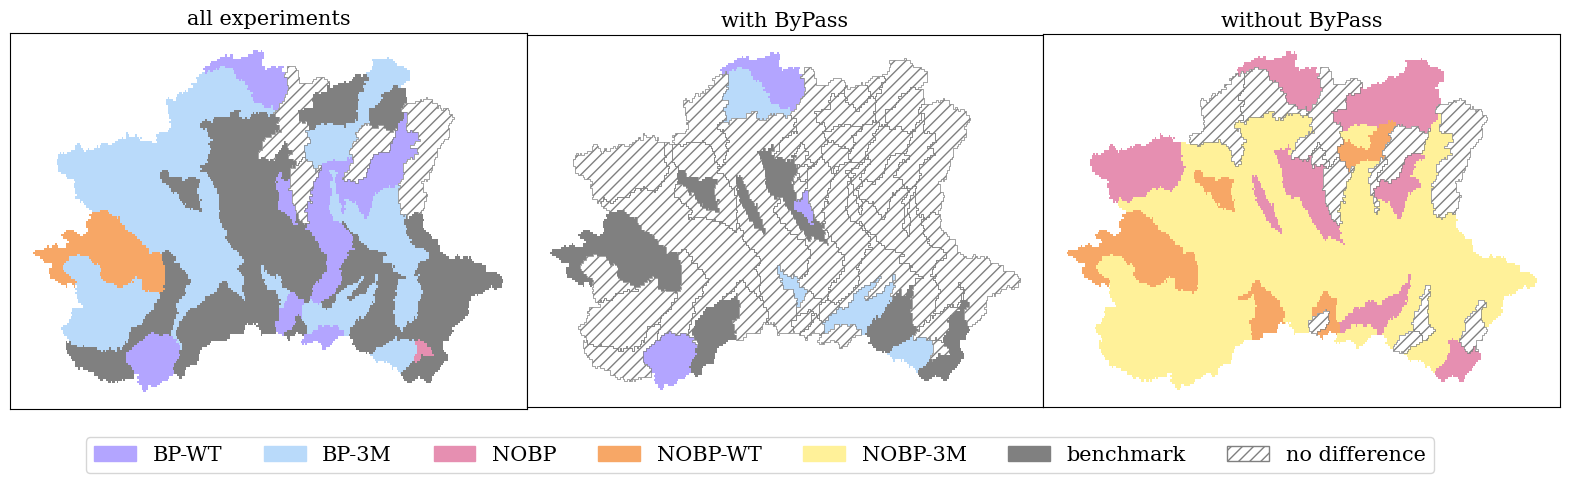

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,7))
best_list=[best_exp,best_BP,best_NBP]
best_list_name=['all experiments','with ByPass','without ByPass']
for i, e in enumerate(best_list):
    # Replace codes with readable labels
    e = e.replace(exp_mapping)

    # Merge with catchments
    temp = catchments.merge(e.rename(best_list_name[i]), right_index=True, left_on='ID', how='left')
    temp[best_list_name[i]] = temp[best_list_name[i]].fillna('missing')

    # Split into normal vs. 'no difference'
    normal = temp[temp[best_list_name[i]] != 'no difference']
    nodiff = temp[temp[best_list_name[i]] == 'no difference']

    # Plot normal areas with color
    normal.plot(ax=ax[i],
                color=normal[best_list_name[i]].map(color_dict))

    # Plot 'no difference' with diagonal hatch
    nodiff.plot(ax=ax[i],
                facecolor='none',
                edgecolor='grey',
                hatch='///',
                linewidth=0.5)

    # Style axes
    ax[i].set_xticks([]), ax[i].set_yticks([])
    ax[i].set_xticklabels([]), ax[i].set_yticklabels([])
    ax[i].set_title(best_list_name[i],size=15)

# ---- Custom legend ----
legend_patches = [
    mpatches.Patch(color=color_dict[k], label=k)
    for k in color_dict
]

# Add hatch for 'no difference'
hatched_patch = mpatches.Patch(facecolor='white', edgecolor='grey', hatch='///', label='no difference')
legend_patches.append(hatched_patch)

# Add legend under the plots
fig.legend(prop={'size': 15},handles=legend_patches, loc='lower center', ncol=7, bbox_to_anchor=(0.5, 0.14))

# Adjust spacing to fit legend
fig.subplots_adjust(wspace=0, bottom=0.15)

# Save figure
fig.savefig(os.path.join(out_dir,'calib_comparison_KGE.png'),
            bbox_inches='tight')

plot parameters

'UpperZoneTimeConstant',
       'LowerZoneTimeConstant', 'GwPercValue', 'LZThreshold', 'b_Xinanjiang',
       'PowerPrefFlow', 'SnowMeltCoef', 'CalChanMan1', 'CalChanMan2',
       'LakeMultiplier', 'adjust_Normal_Flood', 'ReservoirRnormqMult',
       'QSplitMult', 'GwLoss', 'Kling Gupta Efficiency', 'Correlation',
       'Signal ratio (s/o) (Bias)', 'Noise ratio (s/o) (Spread)', 'sae'
var2print

In [94]:
var2print_list=['UpperZoneTimeConstant','LowerZoneTimeConstant', 'GwPercValue', 'LZThreshold', 'b_Xinanjiang','PowerPrefFlow', 'SnowMeltCoef', 'CalChanMan1', 'CalChanMan2','LakeMultiplier', 'adjust_Normal_Flood', 'ReservoirRnormqMult','QSplitMult', 'GwLoss']
var2print_list_m=[['UpperZoneTimeConstant','LowerZoneTimeConstant', 'GwPercValue', 'LZThreshold', 'b_Xinanjiang','PowerPrefFlow', 'SnowMeltCoef'], ['CalChanMan1', 'CalChanMan2','LakeMultiplier', 'adjust_Normal_Flood', 'ReservoirRnormqMult','QSplitMult', 'GwLoss']]

In [95]:
for var2print in var2print_list:
    print(var2print)
    for e in exp_names:
        test=stats.kstest(summary_dict['benchmark'][var2print], summary_dict[e][var2print])
        # print(test[1])
        if test[1]<0.04:
            print(f'{e} different dist from benchmark')
            # print(test[1])

UpperZoneTimeConstant
NOBPNEWSD different dist from benchmark
NOBPNEWSD3 different dist from benchmark
LowerZoneTimeConstant
NOBPNEWSD3 different dist from benchmark
GwPercValue
LZThreshold
NOBP different dist from benchmark
NOBPNEWSD different dist from benchmark
b_Xinanjiang
NOBP different dist from benchmark
NOBPNEWSD different dist from benchmark
NOBPNEWSD3 different dist from benchmark
PowerPrefFlow
SnowMeltCoef
CalChanMan1
NOBP different dist from benchmark
NOBPNEWSD different dist from benchmark
NOBPNEWSD3 different dist from benchmark
CalChanMan2
NOBP different dist from benchmark
NOBPNEWSD different dist from benchmark
NOBPNEWSD3 different dist from benchmark
LakeMultiplier
adjust_Normal_Flood
ReservoirRnormqMult
QSplitMult
NOBP different dist from benchmark
NOBPNEWSD different dist from benchmark
NOBPNEWSD3 different dist from benchmark
GwLoss


In [96]:
for e in exp_names:
    KGE_t=summary_dict[e]
    KGE_t['exp']=e
    if 'calib_data' in locals():
        # calib_data=calib_data.append(KGE_t)
        calib_data=pd.concat([calib_data, KGE_t], ignore_index=True)
    else:
        calib_data=KGE_t.copy()
        


In [97]:
# assign dummy vlues to powerPrefflow
calib_data['PowerPrefFlow'][~calib_data['exp'].isin(['benchmark','BPNEWSD','BPNEWSD3'])]=1

In [98]:
exp_title=['NOBP', 'NOBPWT', 'NOBP3M', 'benchmark', 'BP3M', 'BPWT']
# Define the mapping from old to new names
exp_mapping = {
    'NOBP': 'NOBP',
    'NOBPNEWSD': 'NOBP-WT',
    'NOBPNEWSD3': 'NOBP-3M',
    'benchmark': 'benchmark',
    'BPNEWSD3': 'BP-3M',
    'BPNEWSD': 'BP-WT'
}


Plot frequency of parameters

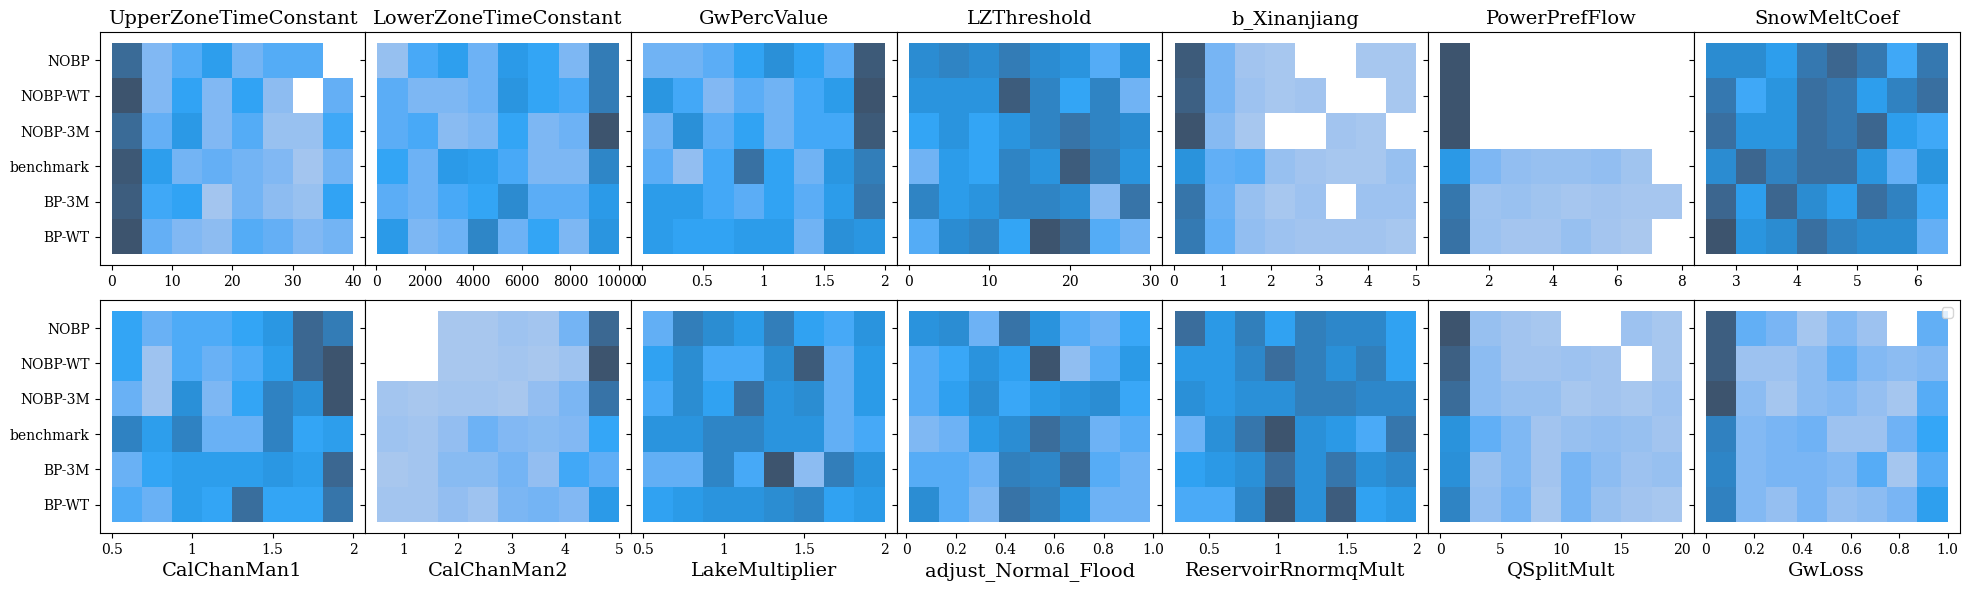

In [100]:
fig = plt.figure(figsize = (24,6.5))
ax=fig.subplot_mosaic(var2print_list_m)
plt.subplots_adjust(wspace=0, hspace=0.15)
calib_data['exp'] = calib_data['exp'].replace(exp_mapping)

for var2print in var2print_list:
    # if var2print=='PowerPrefFlow':
    #     calib_sel=calib_data[~calib_data['exp'].isin(['benchmark','BPNEWSD','BPNEWSD3'])]
    # sns.histplot(calib_data, x=var2print, hue="exp",  element="poly",ax=ax[var2print], fill=False,legend=False)

    sns.histplot(calib_data, x=var2print, y="exp",  legend=True,ax=ax[var2print],bins=8, stat='count')
    if var2print in var2print_list_m[0]:
        ax[var2print].set_title(var2print,size=14)
        ax[var2print].set_xlabel('')
    else:
        ax[var2print].xaxis.get_label().set_fontsize(14)
    if var2print not in [var2print_list_m[0][0],var2print_list_m[1][0]]:
        ax[var2print].set_ylabel('')
        ax[var2print].set_yticklabels('')
    ax[var2print].set_ylabel('')
    ax[var2print].xaxis.set_major_formatter(formatter)
ax[var2print].legend()
fig.savefig(os.path.join(out_dir,'paramenters_frequency.png'), bbox_inches="tight")


In [101]:
exp_title=['NOBP', 'NOBP-WT', 'NOBP-3M', 'benchmark', 'BP-3M', 'BP-WT']

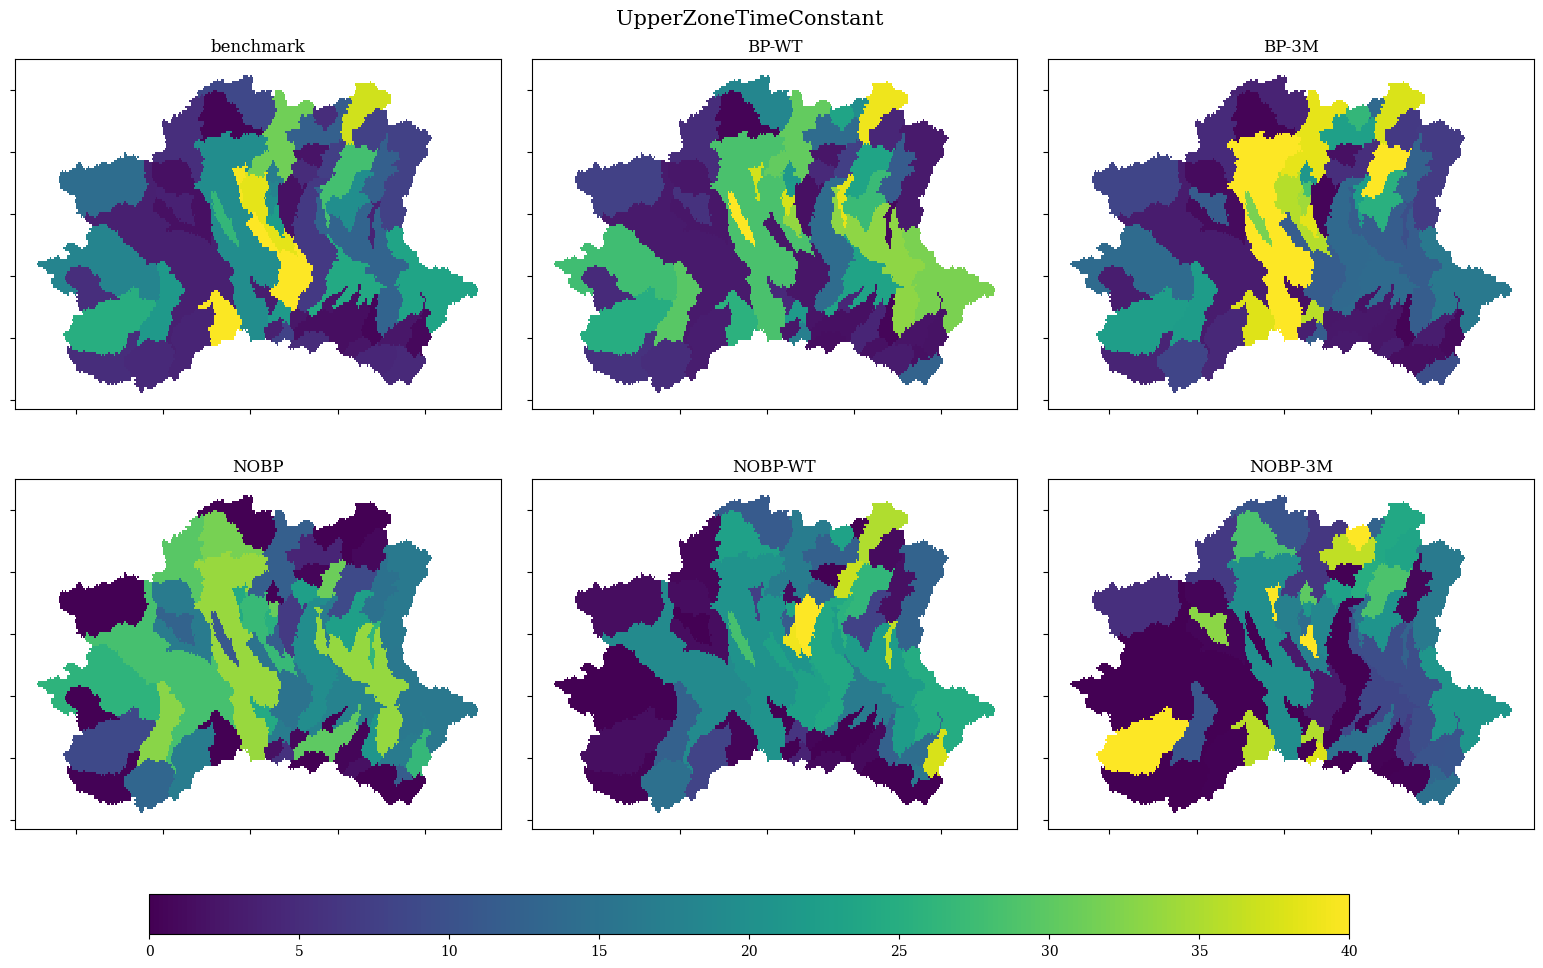

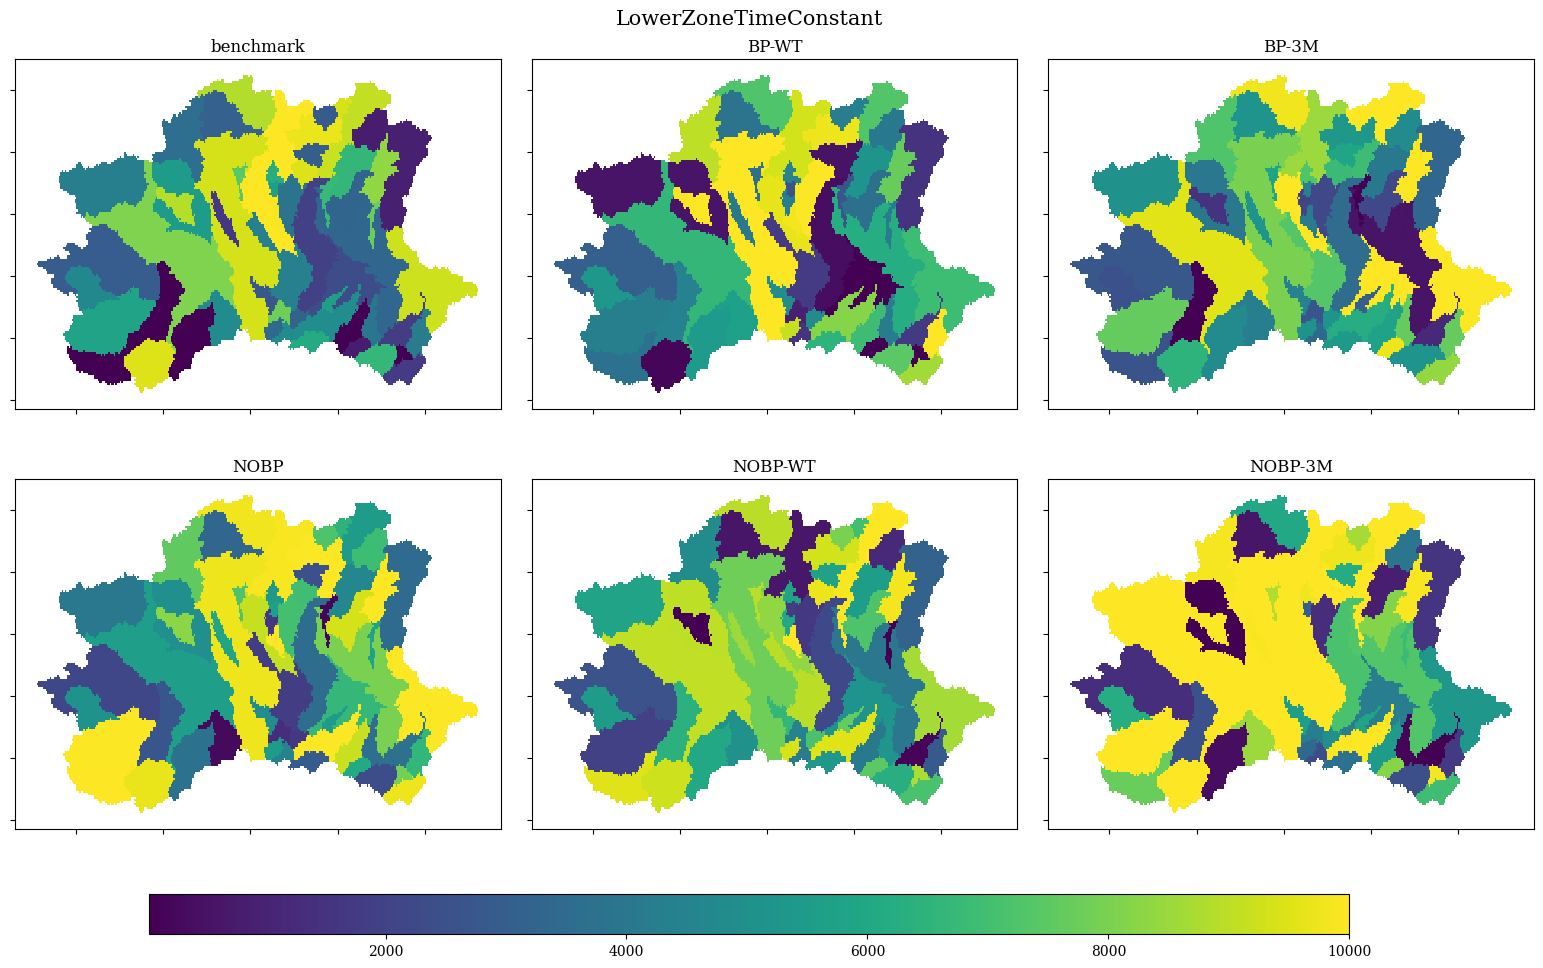

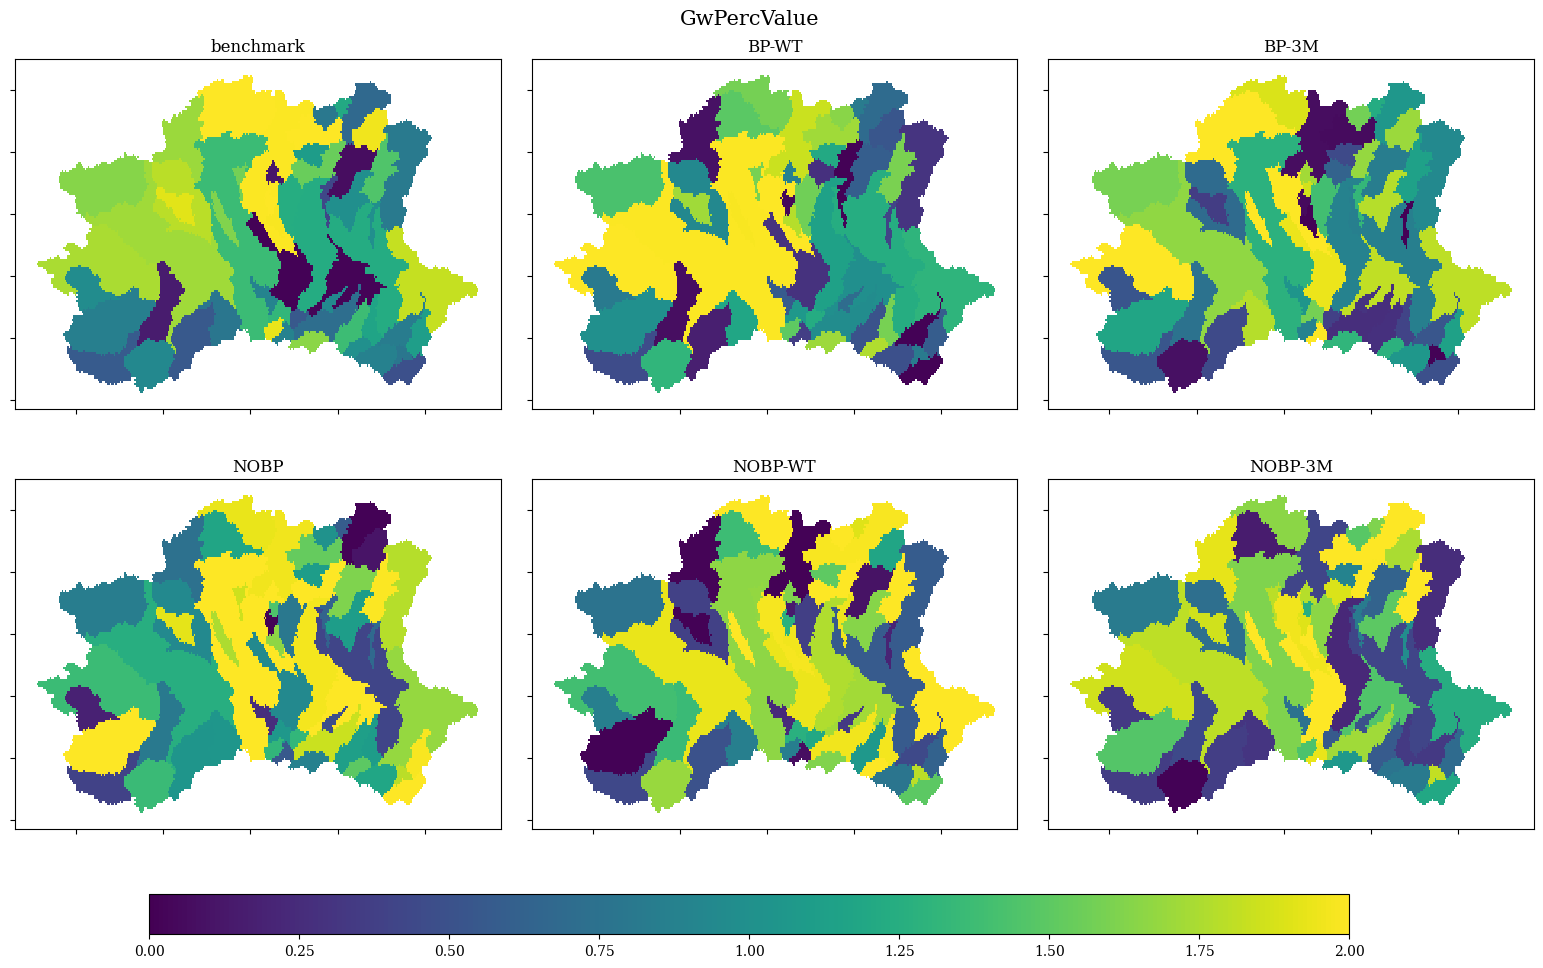

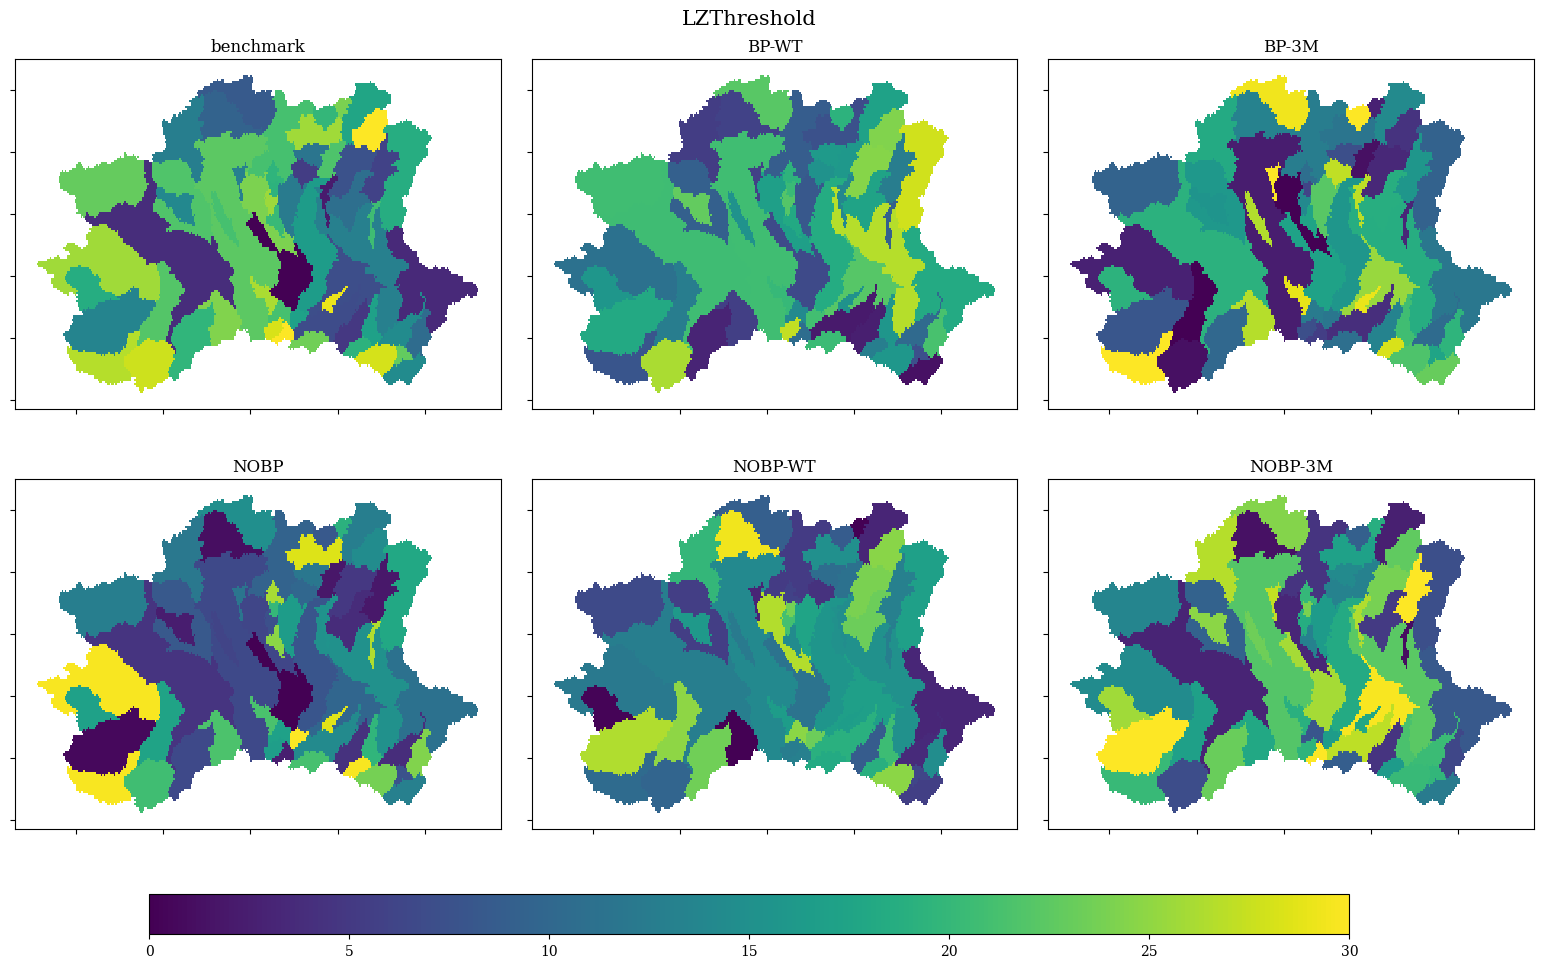

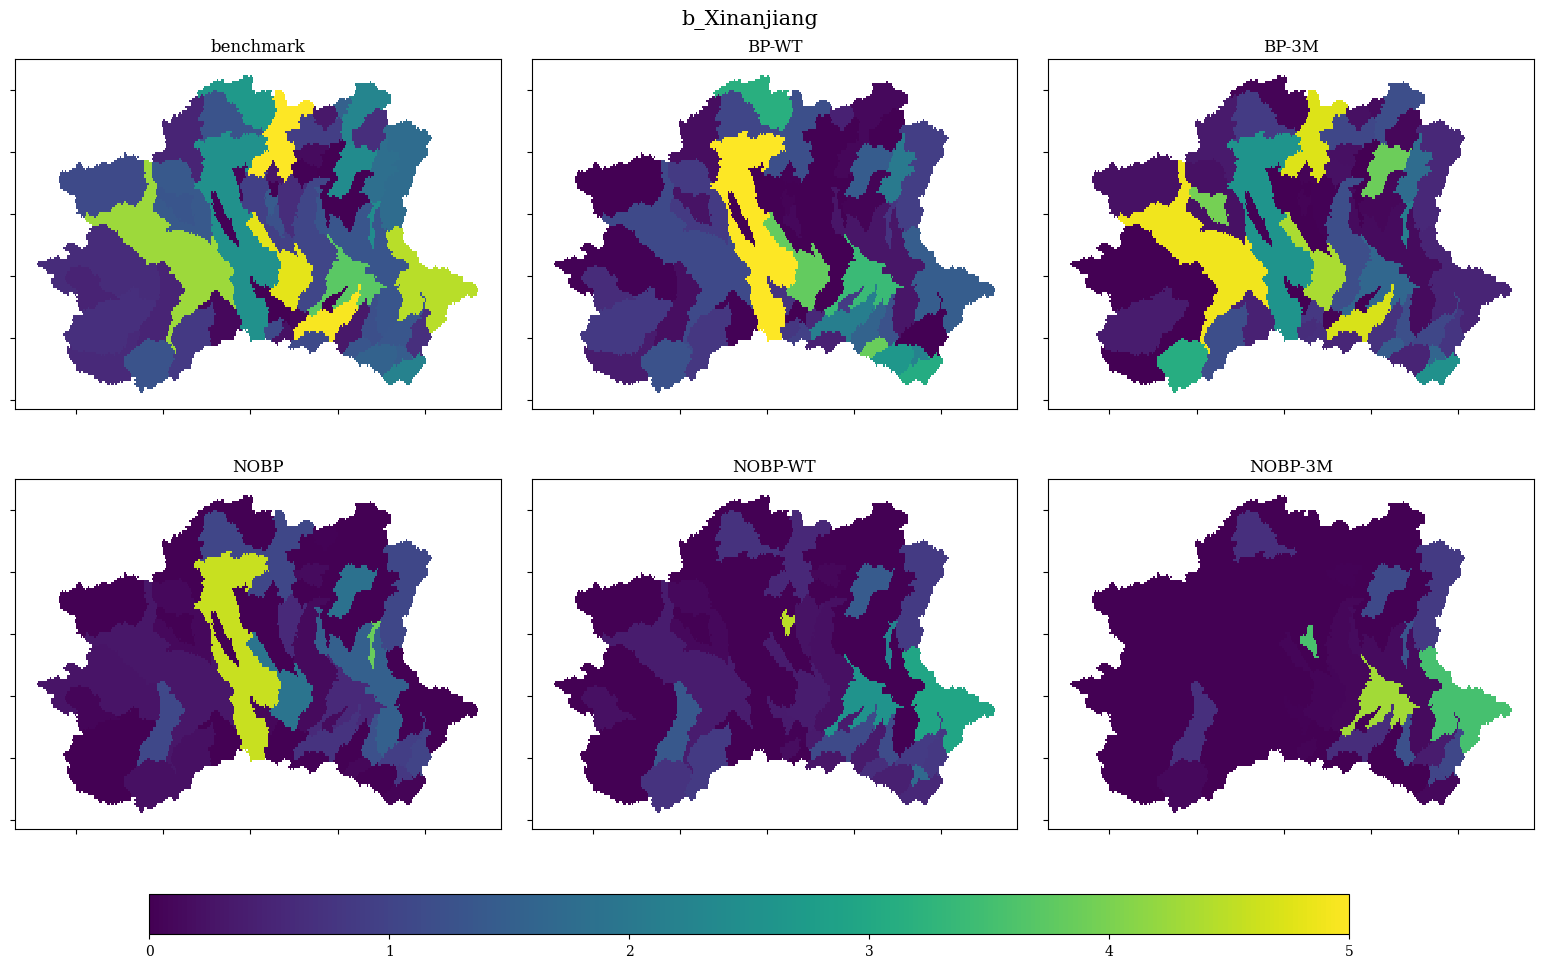

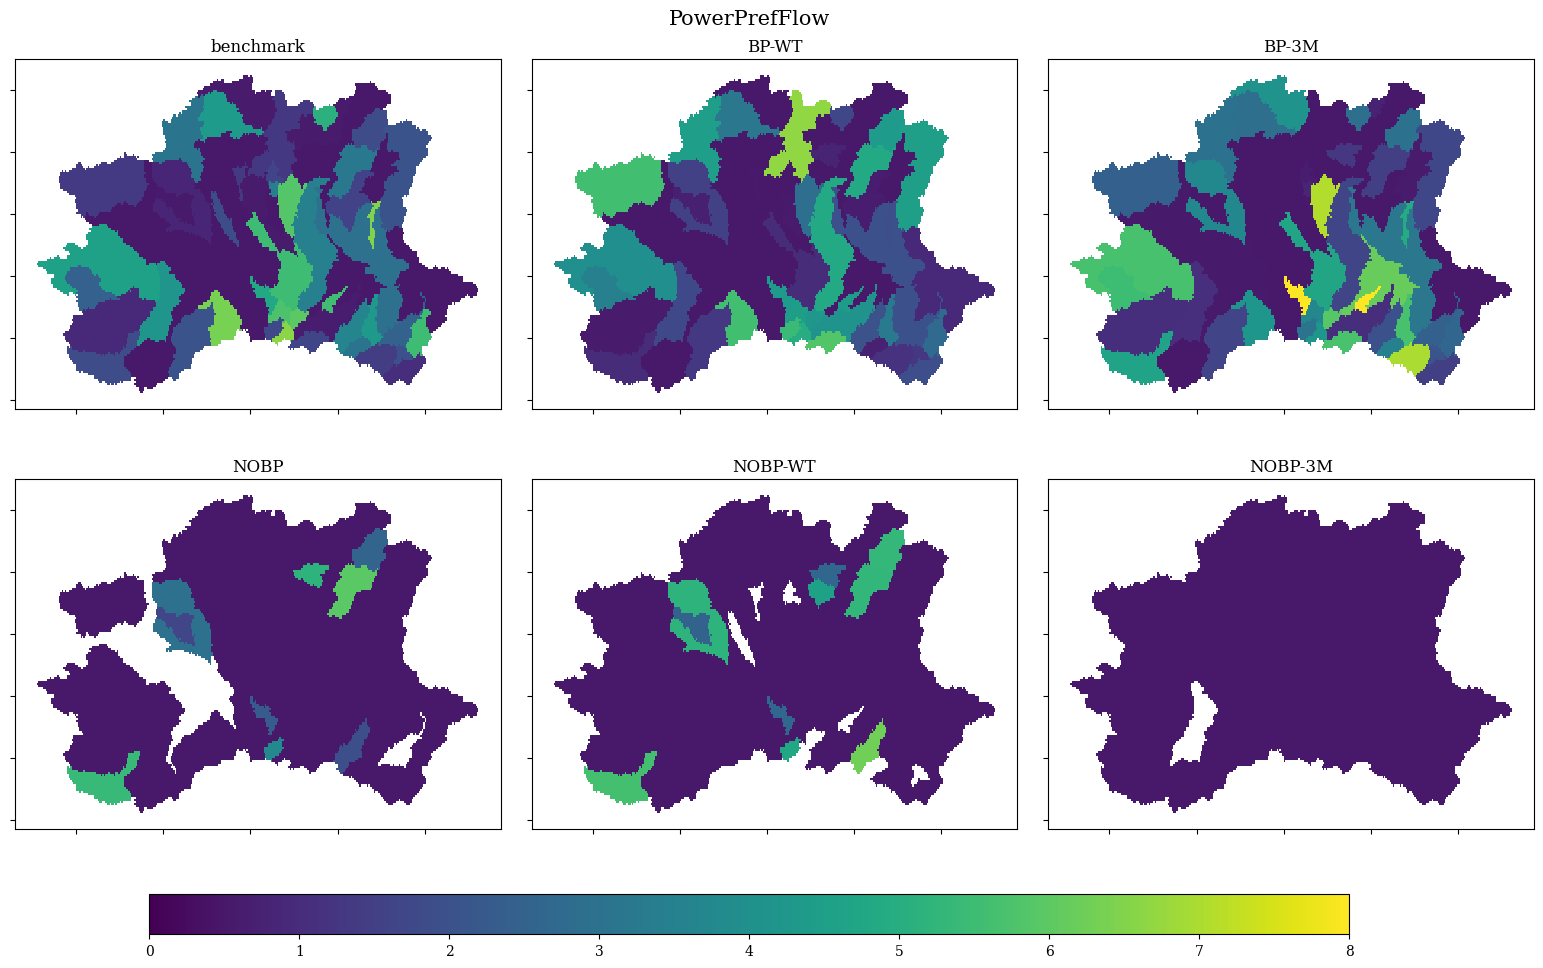

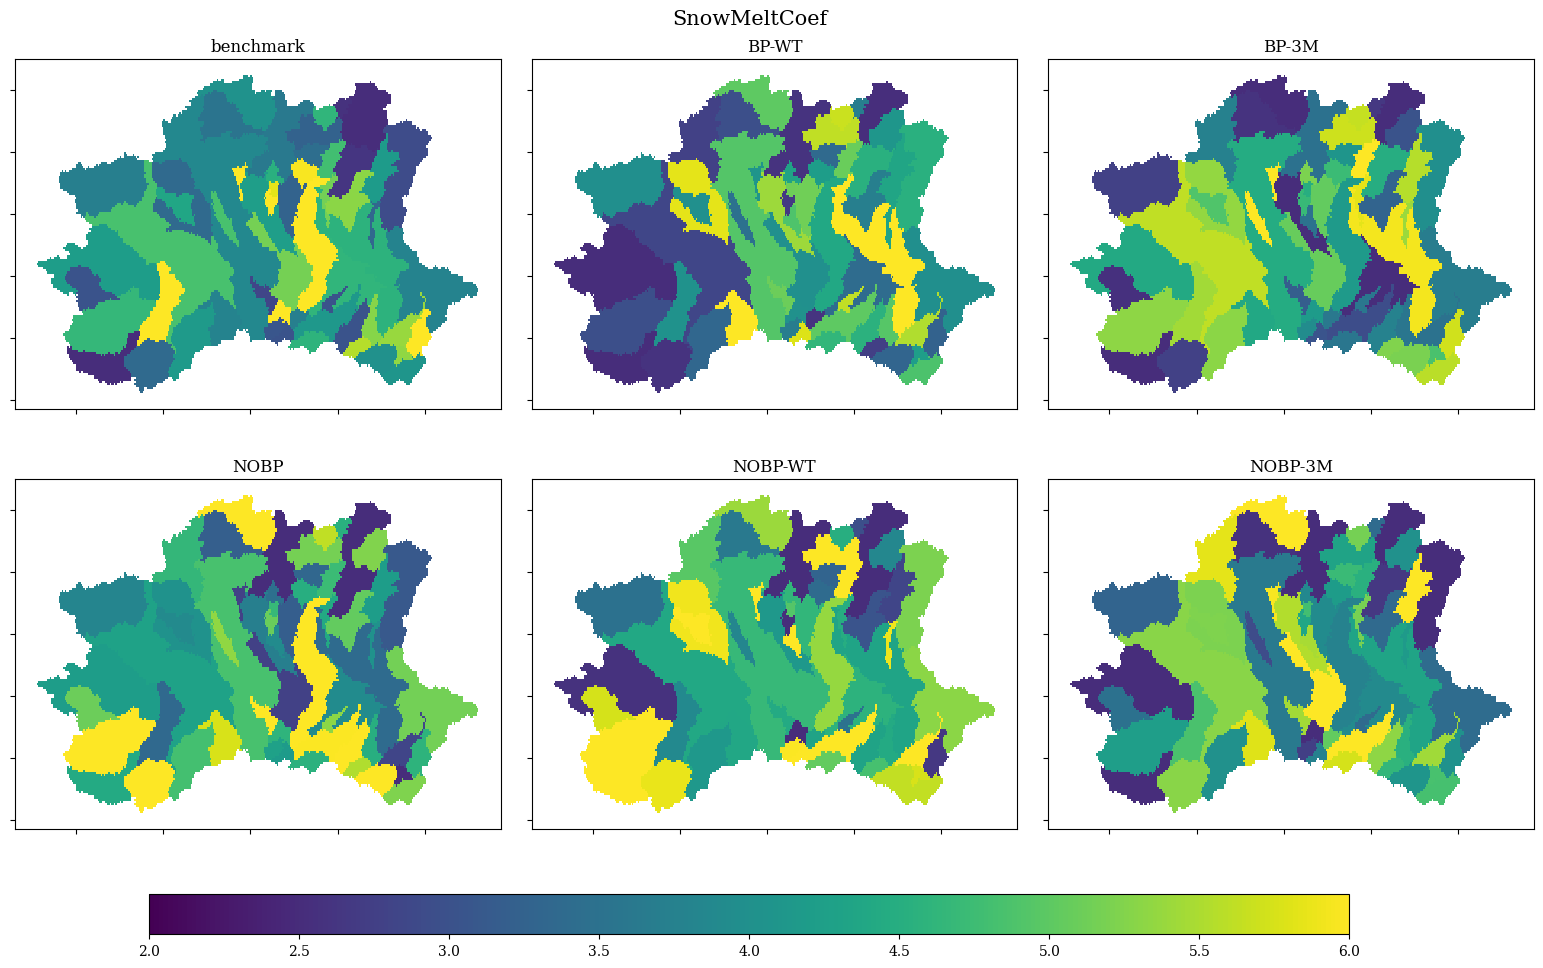

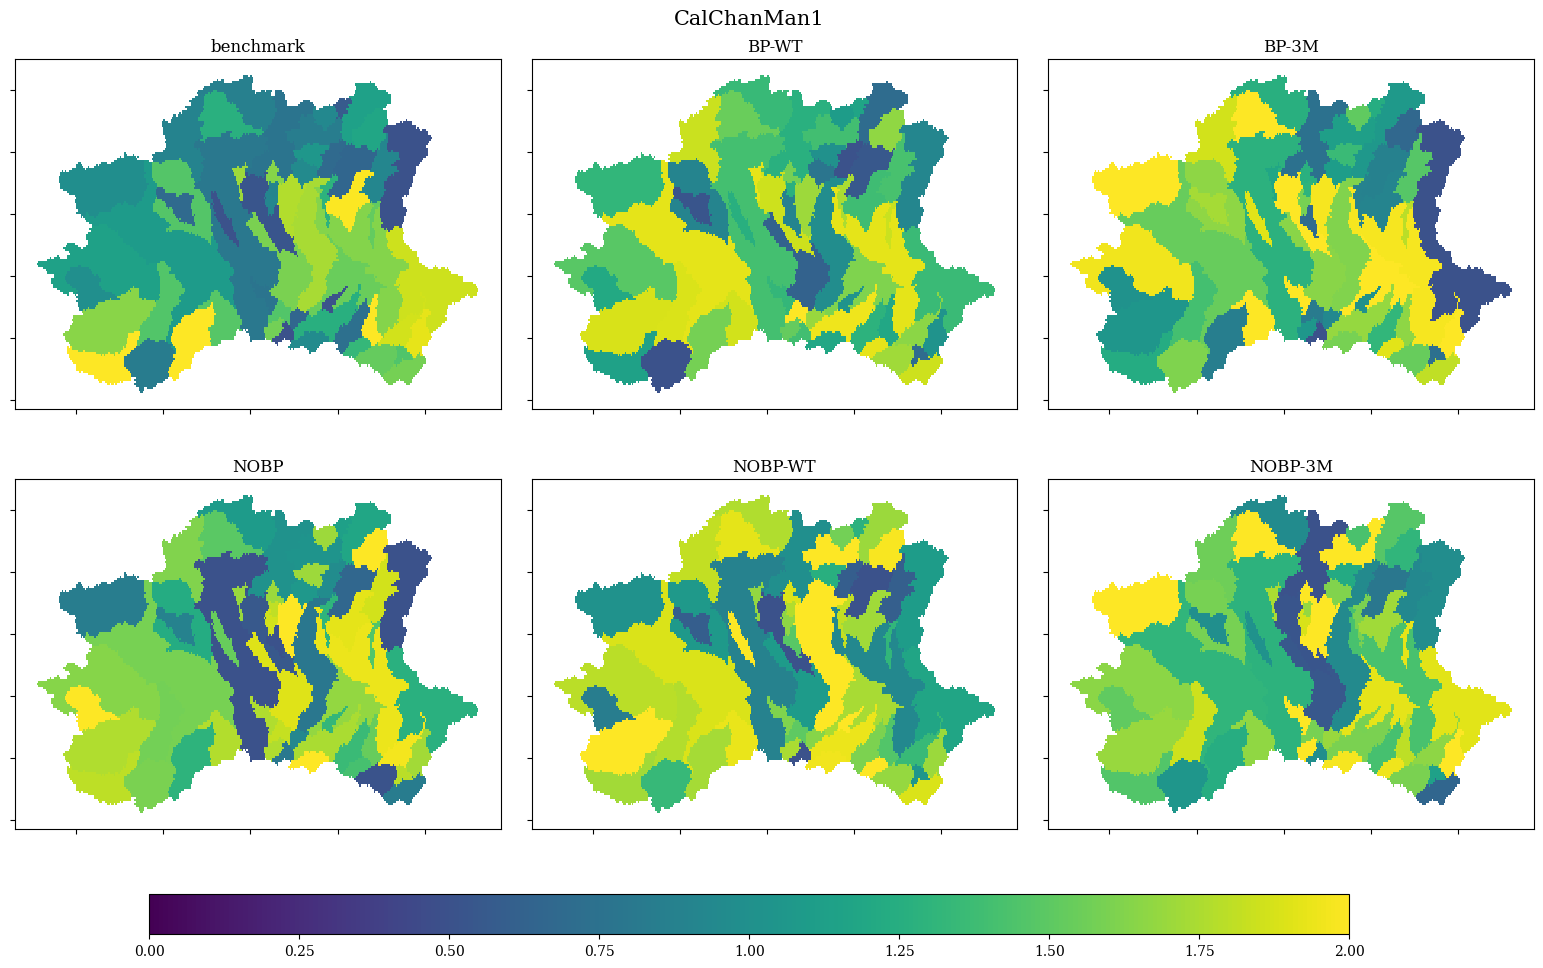

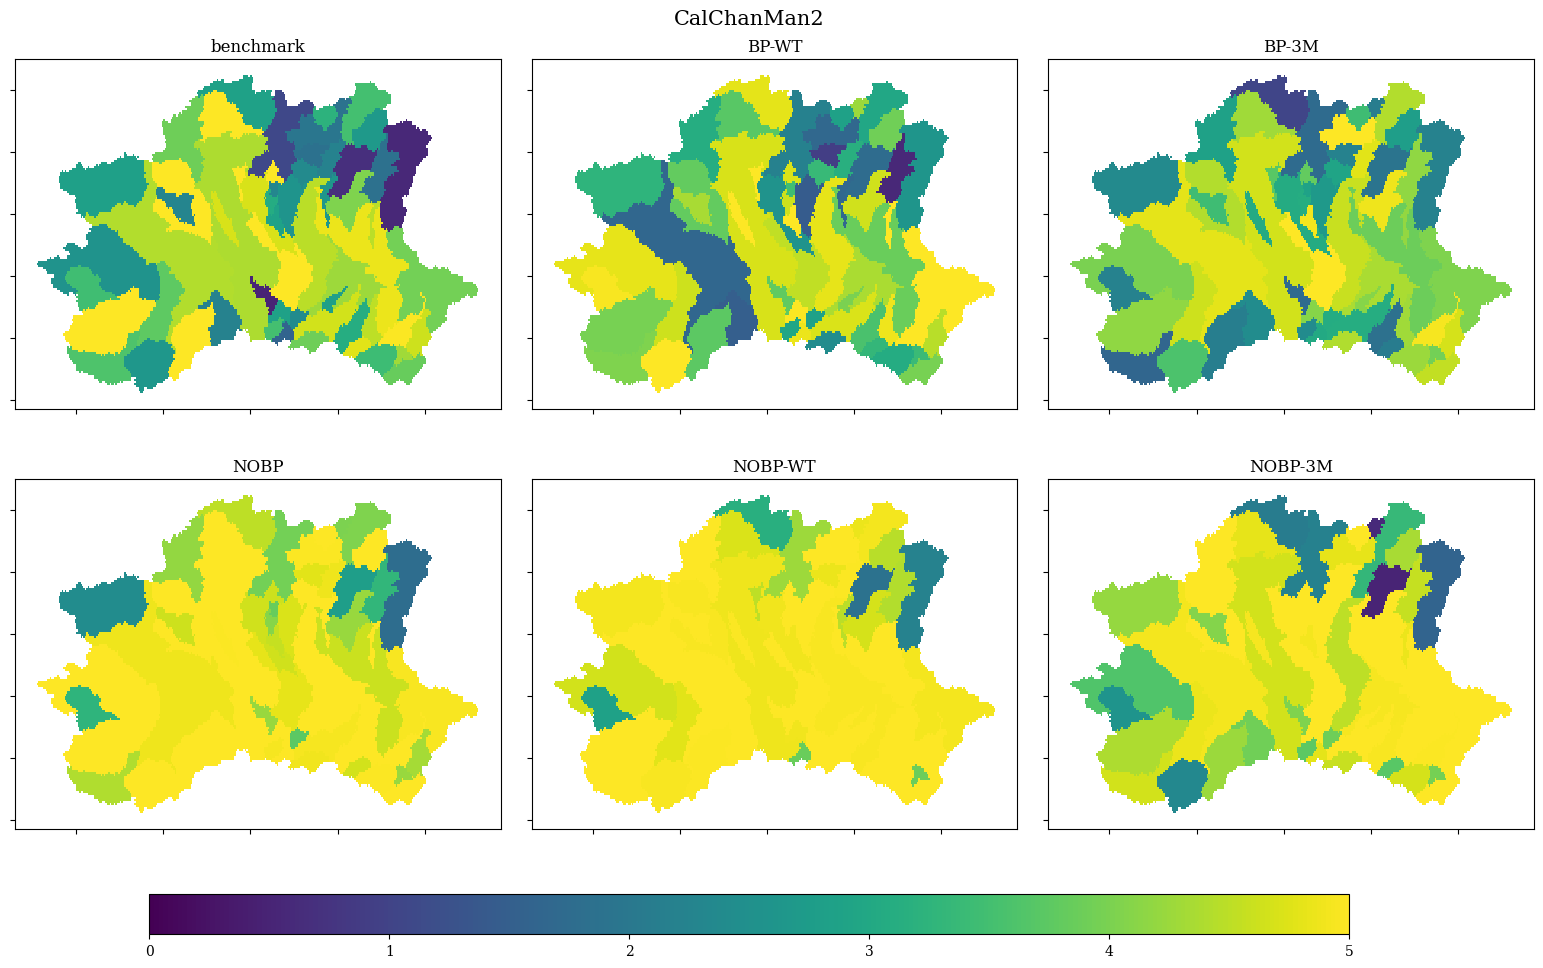

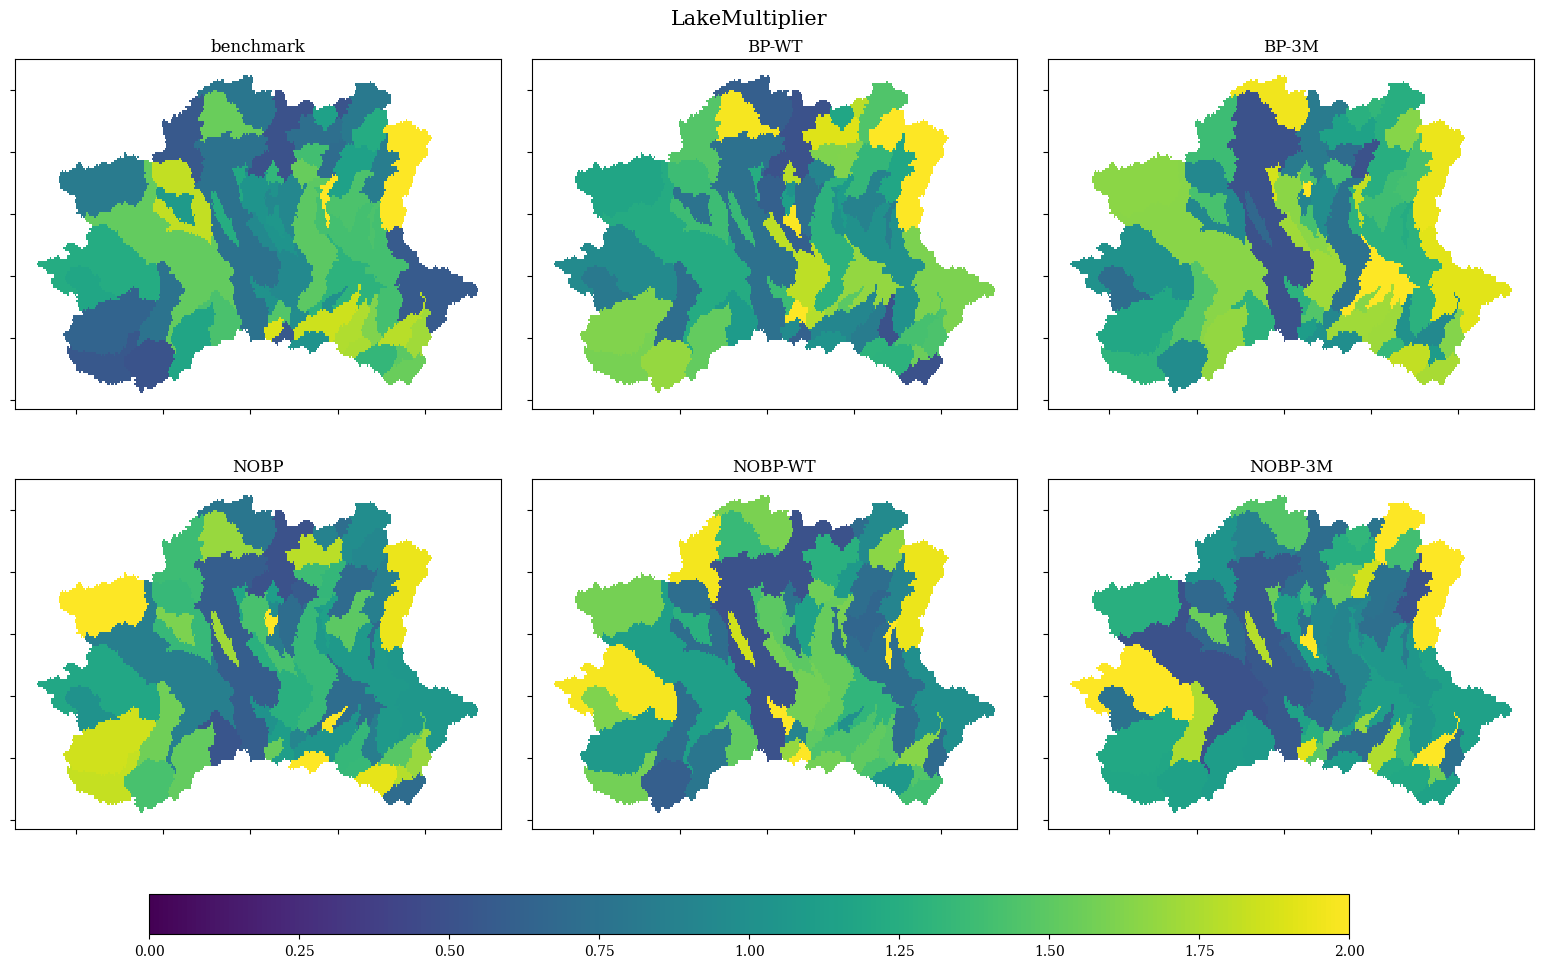

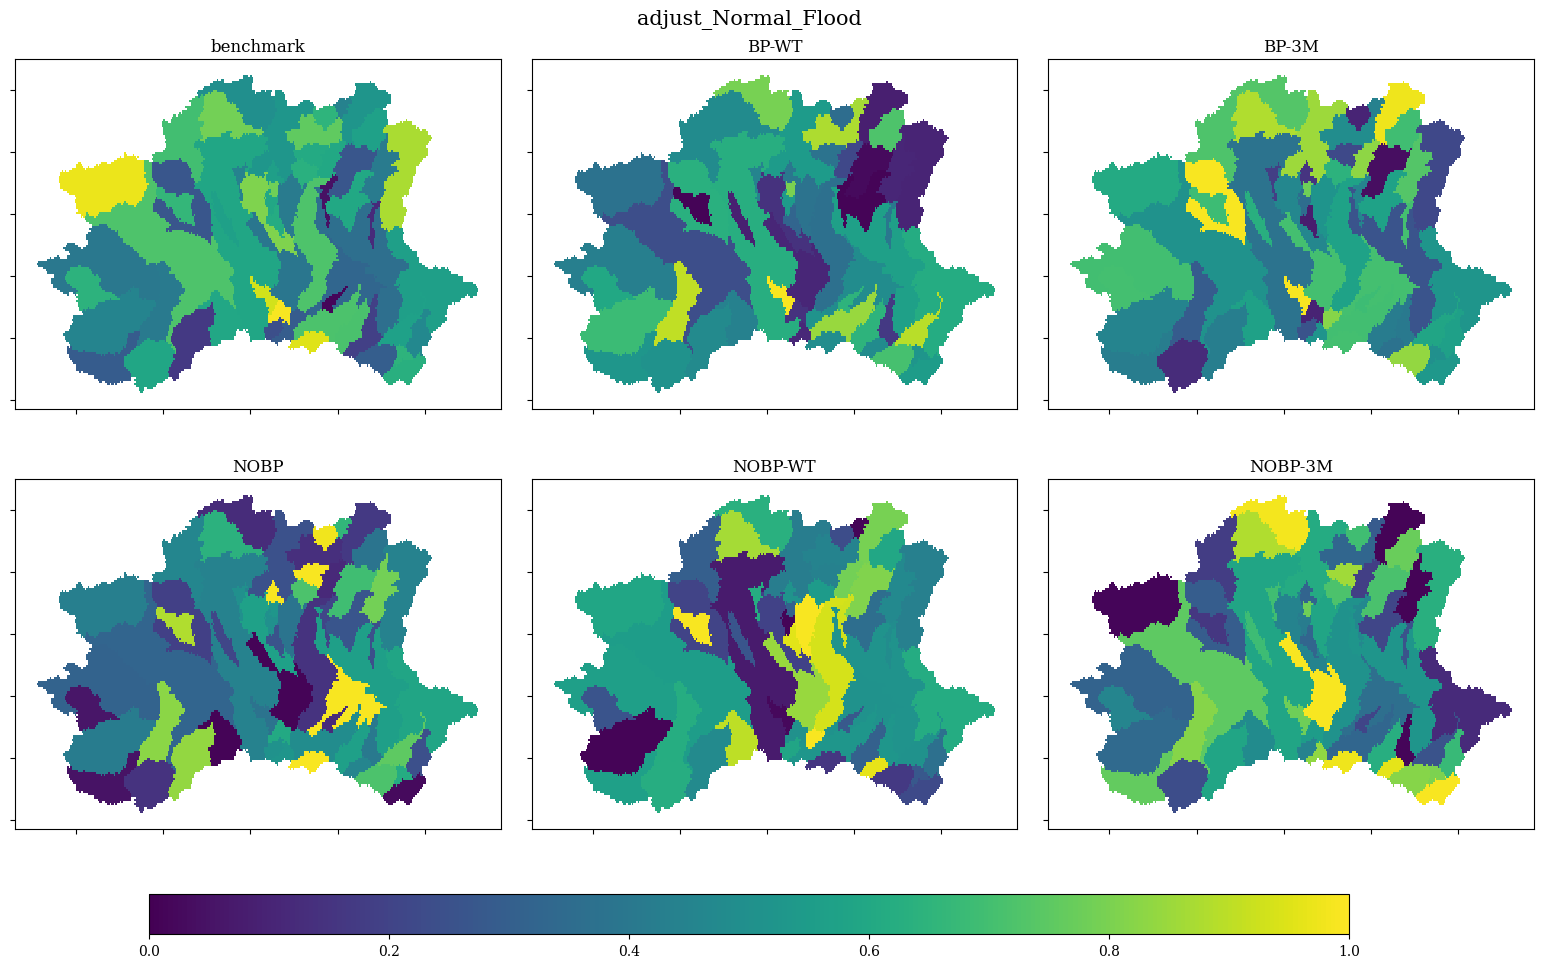

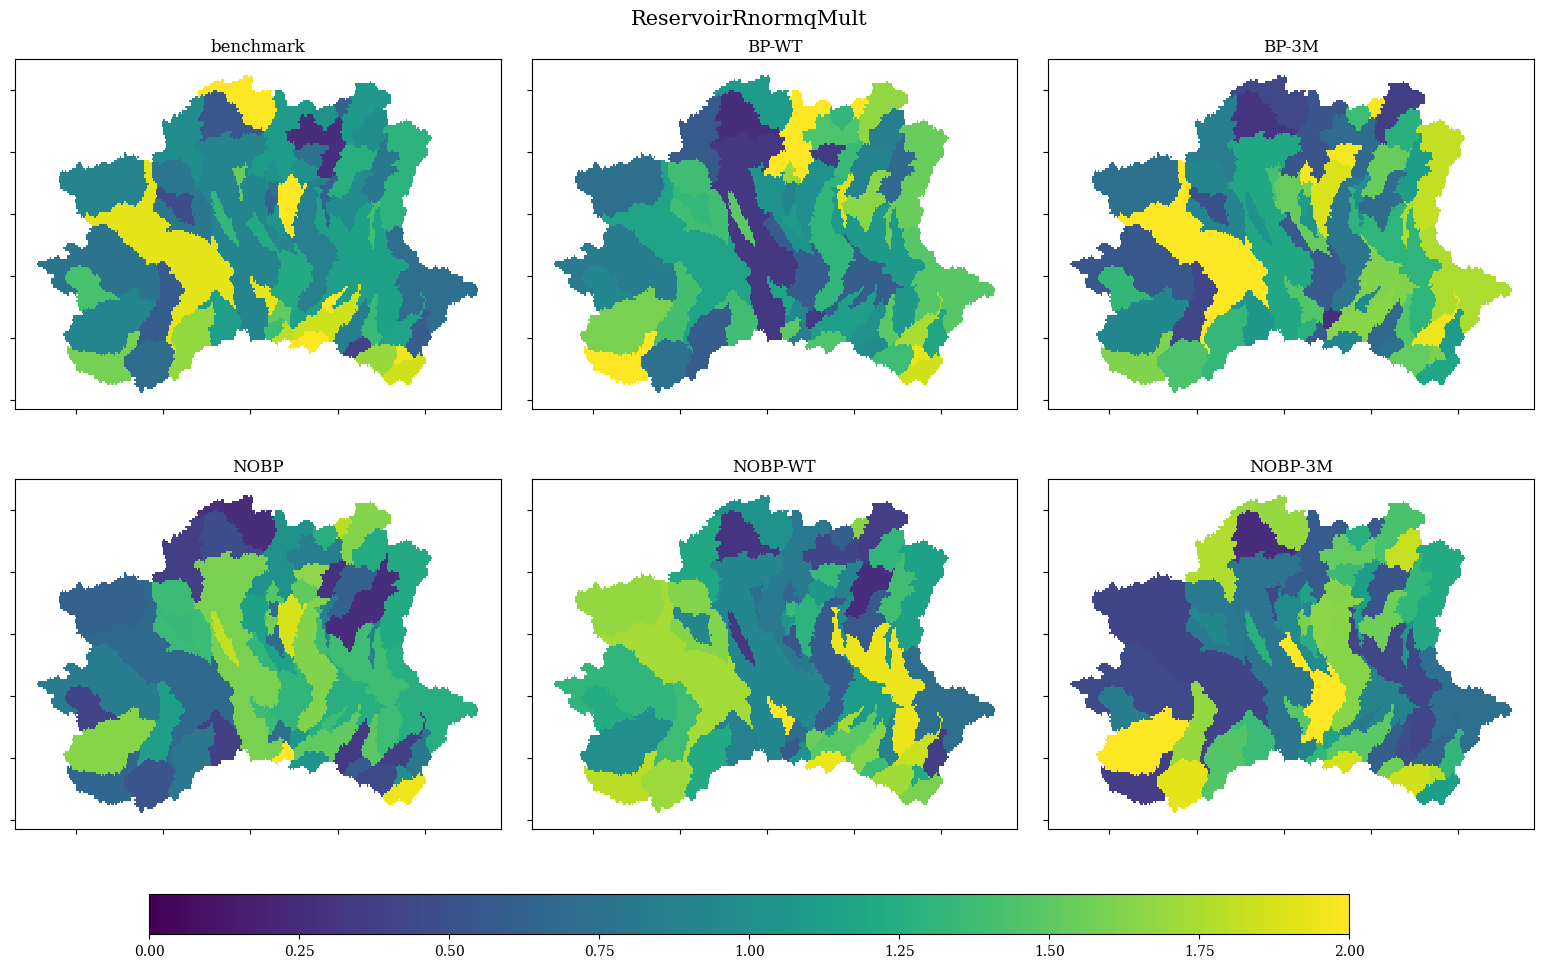

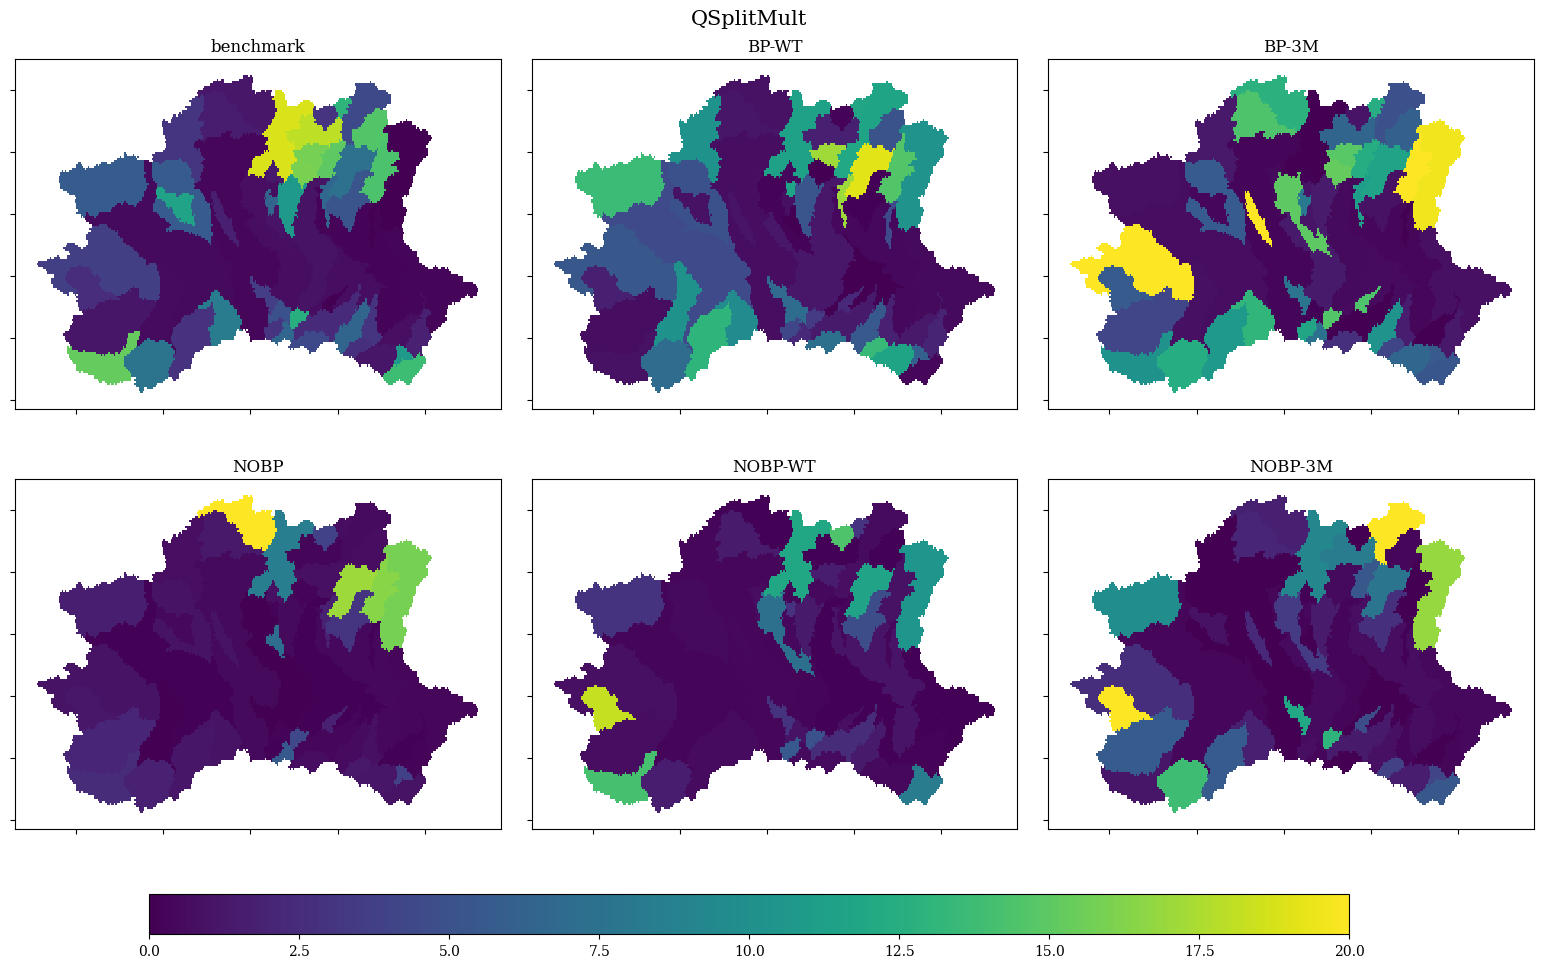

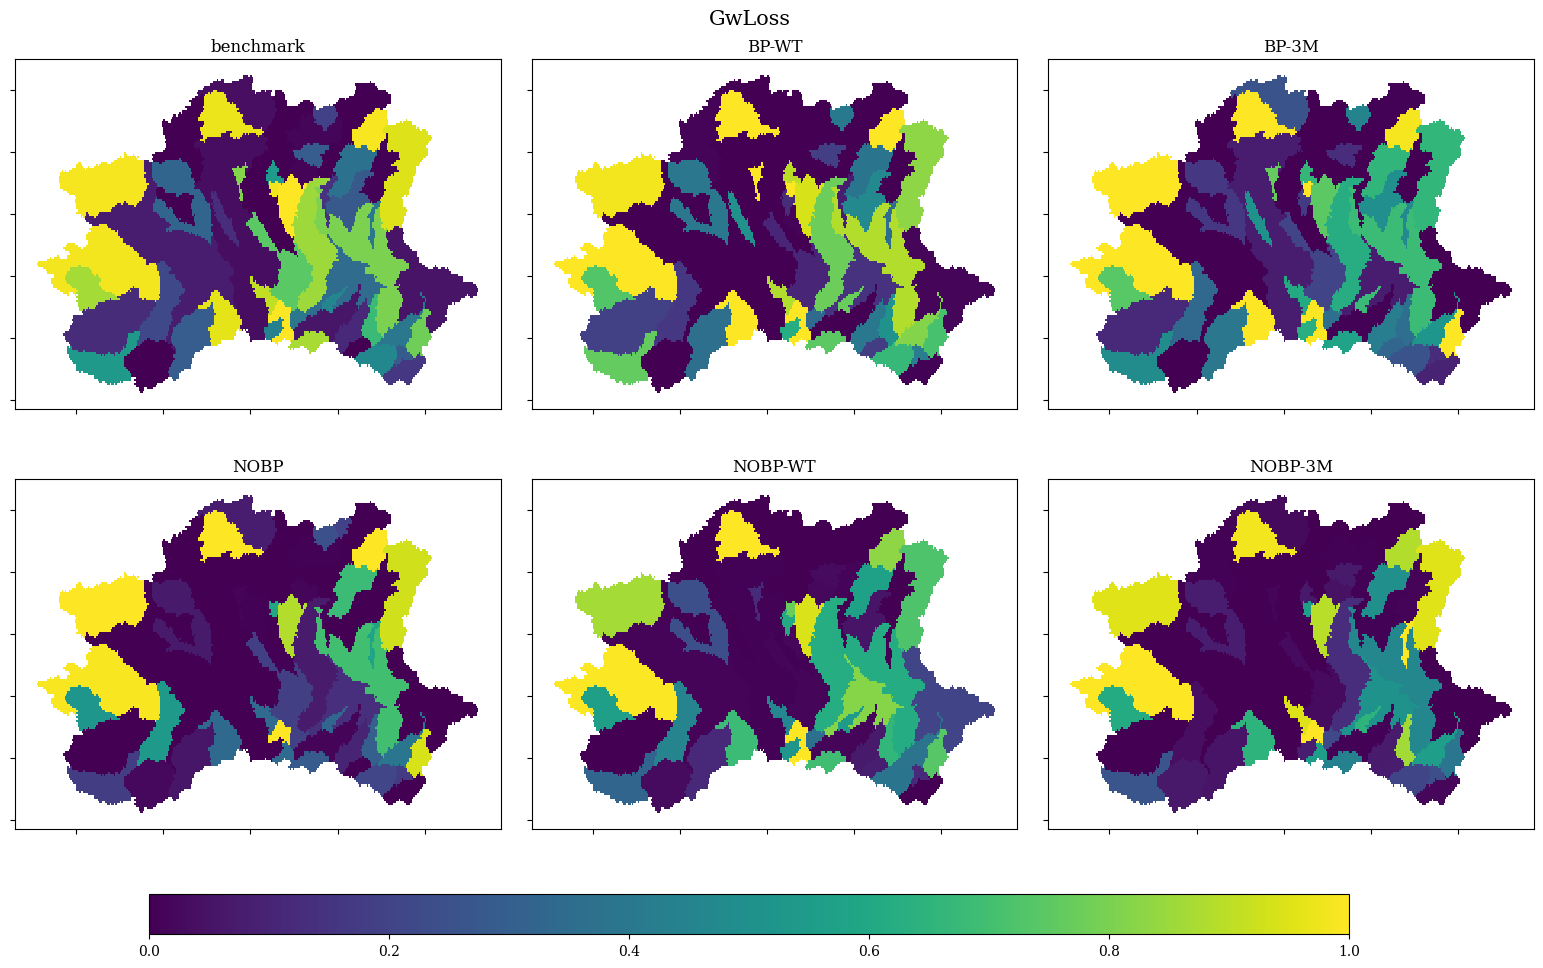

In [ ]:
for var2print in var2print_list:
    cmap = matplotlib.cm.viridis

    #mosaic=[['benchmark','BPNEWSD','BPNEWSD3'],['OLDSD', 'NEWSD', 'NEWSD3']]
    fig = plt.figure(figsize = (20,10))

    ax=fig.subplot_mosaic(mosaic)
    #loop to find min and max
    min_z=summary_dict['benchmark'][var2print].min()
    max_z=summary_dict['benchmark'][var2print].max()
    for e in exp_names:
        min_z=min(summary_dict[e][var2print].min(),min_z)
        max_z=max(summary_dict[e][var2print].max(),max_z)
    norm = plt.Normalize(round(min_z), round(max_z))

    # print(min_z)
    # #create discrete colormap
    # #levels=[min_z,-10,-1,-0.5,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    # mid_value=0
    # mid_value_index=levels.index(mid_value)
    # minP=[levels[0:mid_value_index],'Reds_r']
    # maxP=[levels[mid_value_index+1::],'Greens']
    # midP=[0,'grey']
    # cmap_map=build_cmap(minP,midP,maxP)
    # norm = matplotlib.colors.BoundaryNorm(boundaries=levels, ncolors=cmap_map.N)

    #plot
    for i,e in enumerate(exp_names):
        temp=catchments.merge(summary_dict[e],right_index=True,left_on='ID',how='inner')
        a=temp.plot(ax=ax[e],column=var2print,norm=norm)
        ax[e].set_xticklabels([]),ax[e].set_yticklabels([])
        ax[e].set_title(exp_title[i])
    cbar=fig.add_axes([0.2,0.005,0.6,0.04])
    fig.colorbar(plt.cm.ScalarMappable(norm=norm),
                orientation='horizontal',
                # ax = axes instructs the colormap to extend over all axes
                ax= ax['NOBPNEWSD'],
                # but it's to much, so we shrink it to 75% 
                shrink=0.8,
                pad=-1,
                cax=cbar,
                # and make it a little slimmer
                aspect=30,
                )
    #cbar=fig.add_axes([0.2,0.005,0.6,0.04])
    #cbar = fig.colorbar(a,ax=ax[e], location ='bottom', fraction=0.05)
    # ax['NULL'].axis('off')
    fig.suptitle(var2print, y=0.93,fontsize=15)
    fig.subplots_adjust(wspace=0)

    fig.savefig(os.path.join(out_dir,f'{var2print}.png'),bbox_inches='tight')
#thebar=fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap_map),cax=cbar, orientation = "horizontal",pad=-1)